## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 400000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d  + e + np.random.normal(mean, var, SIZE)

    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    e = np.random.normal(mean, var, SIZE)
    f= a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c = a + np.random.normal(mean, var, SIZE)
    d = a + np.random.normal(mean, var, SIZE)
    e = a + np.random.normal(mean, var, SIZE)
    f= a + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models = 500
model_layers = [2048, 2048, 512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/e' + str(i))

print(models, model_names)


df = gen_data()
X = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y = df['g'].values

val_df = gen_data(SIZE = 2000)
x_val = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y_val = df['g'].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), 6)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/e0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 4s 183us/step - loss: 1.1087 - mean_squared_error: 1.1087 - val_loss: 1.0126 - val_mean_squared_error: 1.0126

Epoch 00001: val_loss improved from inf to 1.01262, saving model to temp/e0
Epoch 2/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0213 - mean_squared_error: 1.0213 - val_loss: 1.0133 - val_mean_squared_error: 1.0133

Epoch 00002: val_loss did not improve from 1.01262
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0164 - mean_squared_error: 1.0164 - val_loss: 1.0061 - val_mean_squared_error: 1.0061

Epoch 00003: val_loss improved from 1.01262 to 1.00605, saving model to temp/e0
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0136 - mean_squared_error: 1.0136 - val_loss: 1.0096 - val_mean_squared_error: 1.0096

Epoch 00004: val_loss did not improve from 1.00605
Epoch 5/


Epoch 00003: val_loss improved from 1.01307 to 1.00941, saving model to temp/e5
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0133 - mean_squared_error: 1.0133 - val_loss: 1.0045 - val_mean_squared_error: 1.0045

Epoch 00004: val_loss improved from 1.00941 to 1.00453, saving model to temp/e5
Epoch 5/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.0112 - mean_squared_error: 1.0112 - val_loss: 1.0032 - val_mean_squared_error: 1.0032

Epoch 00005: val_loss improved from 1.00453 to 1.00315, saving model to temp/e5
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0099 - mean_squared_error: 1.0099 - val_loss: 1.0047 - val_mean_squared_error: 1.0047

Epoch 00006: val_loss did not improve from 1.00315
Epoch 7/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0120 - mean_squared_error: 1.0120 - val_loss: 1.0017 - val_mean_squared_error: 1.0017

Epoch 00007: val_loss improved f


Epoch 00004: val_loss did not improve from 1.00952
Epoch 00004: early stopping
temp/e11
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 1.1036 - mean_squared_error: 1.1036 - val_loss: 1.0204 - val_mean_squared_error: 1.0204

Epoch 00001: val_loss improved from inf to 1.02044, saving model to temp/e11
Epoch 2/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0220 - mean_squared_error: 1.0220 - val_loss: 1.0116 - val_mean_squared_error: 1.0116

Epoch 00002: val_loss improved from 1.02044 to 1.01158, saving model to temp/e11
Epoch 3/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0143 - mean_squared_error: 1.0143 - val_loss: 1.0070 - val_mean_squared_error: 1.0070

Epoch 00003: val_loss improved from 1.01158 to 1.00700, saving model to temp/e11
Epoch 4/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0164 - mean_squared_error: 1.0164

20000/20000 [==============================] - 3s 137us/step - loss: 1.0073 - mean_squared_error: 1.0073 - val_loss: 1.0204 - val_mean_squared_error: 1.0204

Epoch 00005: val_loss did not improve from 1.01063
Epoch 6/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0080 - mean_squared_error: 1.0080 - val_loss: 1.0031 - val_mean_squared_error: 1.0031

Epoch 00006: val_loss improved from 1.01063 to 1.00306, saving model to temp/e15
Epoch 7/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0074 - mean_squared_error: 1.0074 - val_loss: 0.9984 - val_mean_squared_error: 0.9984

Epoch 00007: val_loss improved from 1.00306 to 0.99845, saving model to temp/e15
Epoch 8/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0110 - mean_squared_error: 1.0110 - val_loss: 1.0039 - val_mean_squared_error: 1.0039

Epoch 00008: val_loss did not improve from 0.99845
Epoch 9/20
20000/20000 [==============================] - 3s 137us/step

20000/20000 [==============================] - 3s 140us/step - loss: 1.0095 - mean_squared_error: 1.0095 - val_loss: 1.0030 - val_mean_squared_error: 1.0030

Epoch 00007: val_loss improved from 1.00323 to 1.00302, saving model to temp/e19
Epoch 8/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0067 - mean_squared_error: 1.0067 - val_loss: 1.0029 - val_mean_squared_error: 1.0029

Epoch 00008: val_loss improved from 1.00302 to 1.00295, saving model to temp/e19
Epoch 9/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0039 - mean_squared_error: 1.0039 - val_loss: 1.0018 - val_mean_squared_error: 1.0018

Epoch 00009: val_loss improved from 1.00295 to 1.00175, saving model to temp/e19
Epoch 10/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0064 - mean_squared_error: 1.0064 - val_loss: 1.0036 - val_mean_squared_error: 1.0036

Epoch 00010: val_loss did not improve from 1.00175
Epoch 11/20
20000/20000 [===============

20000/20000 [==============================] - 3s 137us/step - loss: 1.0075 - mean_squared_error: 1.0075 - val_loss: 1.0237 - val_mean_squared_error: 1.0237

Epoch 00005: val_loss did not improve from 1.00403
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0090 - mean_squared_error: 1.0090 - val_loss: 1.0100 - val_mean_squared_error: 1.0100

Epoch 00006: val_loss did not improve from 1.00403
Epoch 00006: early stopping
temp/e24
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 1.1051 - mean_squared_error: 1.1051 - val_loss: 1.0197 - val_mean_squared_error: 1.0197

Epoch 00001: val_loss improved from inf to 1.01970, saving model to temp/e24
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0198 - mean_squared_error: 1.0198 - val_loss: 1.0101 - val_mean_squared_error: 1.0101

Epoch 00002: val_loss improved from 1.01970 to 1.01012, saving model 

20000/20000 [==============================] - 3s 138us/step - loss: 1.0064 - mean_squared_error: 1.0064 - val_loss: 0.9998 - val_mean_squared_error: 0.9998

Epoch 00010: val_loss improved from 1.00208 to 0.99977, saving model to temp/e27
Epoch 11/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0060 - mean_squared_error: 1.0060 - val_loss: 1.0057 - val_mean_squared_error: 1.0057

Epoch 00011: val_loss did not improve from 0.99977
Epoch 12/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0035 - mean_squared_error: 1.0035 - val_loss: 0.9979 - val_mean_squared_error: 0.9979

Epoch 00012: val_loss improved from 0.99977 to 0.99786, saving model to temp/e27
Epoch 13/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0013 - mean_squared_error: 1.0013 - val_loss: 1.0004 - val_mean_squared_error: 1.0004

Epoch 00013: val_loss did not improve from 0.99786
Epoch 14/20
20000/20000 [==============================] - 3s 136us/

20000/20000 [==============================] - 3s 139us/step - loss: 1.0184 - mean_squared_error: 1.0184 - val_loss: 1.0105 - val_mean_squared_error: 1.0105

Epoch 00002: val_loss improved from 1.01090 to 1.01051, saving model to temp/e33
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0124 - mean_squared_error: 1.0124 - val_loss: 1.0061 - val_mean_squared_error: 1.0061

Epoch 00003: val_loss improved from 1.01051 to 1.00606, saving model to temp/e33
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0117 - mean_squared_error: 1.0117 - val_loss: 1.0059 - val_mean_squared_error: 1.0059

Epoch 00004: val_loss improved from 1.00606 to 1.00593, saving model to temp/e33
Epoch 5/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0129 - mean_squared_error: 1.0129 - val_loss: 1.0045 - val_mean_squared_error: 1.0045

Epoch 00005: val_loss improved from 1.00593 to 1.00450, saving model to temp/e33
Epoch 6/20


20000/20000 [==============================] - 3s 139us/step - loss: 1.0194 - mean_squared_error: 1.0194 - val_loss: 1.0119 - val_mean_squared_error: 1.0119

Epoch 00002: val_loss improved from 1.02685 to 1.01194, saving model to temp/e37
Epoch 3/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0192 - mean_squared_error: 1.0192 - val_loss: 1.0142 - val_mean_squared_error: 1.0142

Epoch 00003: val_loss did not improve from 1.01194
Epoch 4/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0142 - mean_squared_error: 1.0142 - val_loss: 1.0064 - val_mean_squared_error: 1.0064

Epoch 00004: val_loss improved from 1.01194 to 1.00639, saving model to temp/e37
Epoch 5/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0127 - mean_squared_error: 1.0127 - val_loss: 1.0163 - val_mean_squared_error: 1.0163

Epoch 00005: val_loss did not improve from 1.00639
Epoch 6/20
20000/20000 [==============================] - 3s 137us/step

20000/20000 [==============================] - 3s 135us/step - loss: 1.0091 - mean_squared_error: 1.0091 - val_loss: 1.0036 - val_mean_squared_error: 1.0036

Epoch 00007: val_loss did not improve from 1.00104
Epoch 8/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0077 - mean_squared_error: 1.0077 - val_loss: 1.0100 - val_mean_squared_error: 1.0100

Epoch 00008: val_loss did not improve from 1.00104
Epoch 00008: early stopping
temp/e41
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 1.0934 - mean_squared_error: 1.0934 - val_loss: 1.0168 - val_mean_squared_error: 1.0168

Epoch 00001: val_loss improved from inf to 1.01685, saving model to temp/e41
Epoch 2/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0201 - mean_squared_error: 1.0201 - val_loss: 1.0134 - val_mean_squared_error: 1.0134

Epoch 00002: val_loss improved from 1.01685 to 1.01341, saving model 


Epoch 00002: val_loss did not improve from 1.00714
Epoch 3/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0167 - mean_squared_error: 1.0167 - val_loss: 1.0078 - val_mean_squared_error: 1.0078

Epoch 00003: val_loss did not improve from 1.00714
Epoch 00003: early stopping
temp/e46
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 153us/step - loss: 1.0993 - mean_squared_error: 1.0993 - val_loss: 1.0171 - val_mean_squared_error: 1.0171

Epoch 00001: val_loss improved from inf to 1.01715, saving model to temp/e46
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0165 - mean_squared_error: 1.0165 - val_loss: 1.0079 - val_mean_squared_error: 1.0079

Epoch 00002: val_loss improved from 1.01715 to 1.00792, saving model to temp/e46
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0161 - mean_squared_error: 1.0161 - val_loss: 1.0051 - val_mean


Epoch 00010: val_loss did not improve from 0.99868
Epoch 00010: early stopping
temp/e51
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 147us/step - loss: 1.1067 - mean_squared_error: 1.1067 - val_loss: 1.0175 - val_mean_squared_error: 1.0175

Epoch 00001: val_loss improved from inf to 1.01746, saving model to temp/e51
Epoch 2/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0184 - mean_squared_error: 1.0184 - val_loss: 1.0135 - val_mean_squared_error: 1.0135

Epoch 00002: val_loss improved from 1.01746 to 1.01353, saving model to temp/e51
Epoch 3/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0129 - mean_squared_error: 1.0129 - val_loss: 1.0119 - val_mean_squared_error: 1.0119

Epoch 00003: val_loss improved from 1.01353 to 1.01194, saving model to temp/e51
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0128 - mean_squared_error: 1.0128

20000/20000 [==============================] - 3s 141us/step - loss: 1.0163 - mean_squared_error: 1.0163 - val_loss: 1.0143 - val_mean_squared_error: 1.0143

Epoch 00003: val_loss did not improve from 1.01197
Epoch 4/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0158 - mean_squared_error: 1.0158 - val_loss: 1.0075 - val_mean_squared_error: 1.0075

Epoch 00004: val_loss improved from 1.01197 to 1.00750, saving model to temp/e55
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0099 - mean_squared_error: 1.0099 - val_loss: 1.0062 - val_mean_squared_error: 1.0062

Epoch 00005: val_loss improved from 1.00750 to 1.00616, saving model to temp/e55
Epoch 6/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0095 - mean_squared_error: 1.0095 - val_loss: 1.0054 - val_mean_squared_error: 1.0054

Epoch 00006: val_loss improved from 1.00616 to 1.00544, saving model to temp/e55
Epoch 7/20
20000/20000 [=================


Epoch 00003: val_loss improved from 1.01071 to 1.00917, saving model to temp/e60
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0121 - mean_squared_error: 1.0121 - val_loss: 1.0090 - val_mean_squared_error: 1.0090

Epoch 00004: val_loss improved from 1.00917 to 1.00904, saving model to temp/e60
Epoch 5/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0107 - mean_squared_error: 1.0107 - val_loss: 1.0039 - val_mean_squared_error: 1.0039

Epoch 00005: val_loss improved from 1.00904 to 1.00393, saving model to temp/e60
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0126 - mean_squared_error: 1.0126 - val_loss: 1.0030 - val_mean_squared_error: 1.0030

Epoch 00006: val_loss improved from 1.00393 to 1.00295, saving model to temp/e60
Epoch 7/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0093 - mean_squared_error: 1.0093 - val_loss: 1.0029 - val_mean_squared_error: 1.0029


20000/20000 [==============================] - 3s 139us/step - loss: 1.0075 - mean_squared_error: 1.0075 - val_loss: 1.0170 - val_mean_squared_error: 1.0170

Epoch 00007: val_loss did not improve from 0.99982
Epoch 8/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0074 - mean_squared_error: 1.0074 - val_loss: 1.0012 - val_mean_squared_error: 1.0012

Epoch 00008: val_loss did not improve from 0.99982
Epoch 00008: early stopping
temp/e65
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 149us/step - loss: 1.1016 - mean_squared_error: 1.1016 - val_loss: 1.0195 - val_mean_squared_error: 1.0195

Epoch 00001: val_loss improved from inf to 1.01947, saving model to temp/e65
Epoch 2/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0211 - mean_squared_error: 1.0211 - val_loss: 1.0071 - val_mean_squared_error: 1.0071

Epoch 00002: val_loss improved from 1.01947 to 1.00714, saving model 

20000/20000 [==============================] - 3s 138us/step - loss: 1.0094 - mean_squared_error: 1.0094 - val_loss: 0.9983 - val_mean_squared_error: 0.9983

Epoch 00006: val_loss improved from 1.00638 to 0.99834, saving model to temp/e68
Epoch 7/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0059 - mean_squared_error: 1.0059 - val_loss: 1.0004 - val_mean_squared_error: 1.0004

Epoch 00007: val_loss did not improve from 0.99834
Epoch 8/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0071 - mean_squared_error: 1.0071 - val_loss: 1.0002 - val_mean_squared_error: 1.0002

Epoch 00008: val_loss did not improve from 0.99834
Epoch 00008: early stopping
temp/e69
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 147us/step - loss: 1.1013 - mean_squared_error: 1.1013 - val_loss: 1.0283 - val_mean_squared_error: 1.0283

Epoch 00001: val_loss improved from inf to 1.02832, saving model 

20000/20000 [==============================] - 3s 137us/step - loss: 1.0091 - mean_squared_error: 1.0091 - val_loss: 1.0004 - val_mean_squared_error: 1.0004

Epoch 00008: val_loss improved from 1.00214 to 1.00044, saving model to temp/e73
Epoch 9/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0051 - mean_squared_error: 1.0051 - val_loss: 1.0020 - val_mean_squared_error: 1.0020

Epoch 00009: val_loss did not improve from 1.00044
Epoch 10/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0069 - mean_squared_error: 1.0069 - val_loss: 1.0030 - val_mean_squared_error: 1.0030

Epoch 00010: val_loss did not improve from 1.00044
Epoch 00010: early stopping
temp/e74
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 1.0987 - mean_squared_error: 1.0987 - val_loss: 1.0233 - val_mean_squared_error: 1.0233

Epoch 00001: val_loss improved from inf to 1.02327, saving model

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 148us/step - loss: 1.1029 - mean_squared_error: 1.1029 - val_loss: 1.0219 - val_mean_squared_error: 1.0219

Epoch 00001: val_loss improved from inf to 1.02191, saving model to temp/e79
Epoch 2/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0172 - mean_squared_error: 1.0172 - val_loss: 1.0271 - val_mean_squared_error: 1.0271

Epoch 00002: val_loss did not improve from 1.02191
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0164 - mean_squared_error: 1.0164 - val_loss: 1.0071 - val_mean_squared_error: 1.0071

Epoch 00003: val_loss improved from 1.02191 to 1.00713, saving model to temp/e79
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0129 - mean_squared_error: 1.0129 - val_loss: 1.0067 - val_mean_squared_error: 1.0067

Epoch 00004: val_loss improved from 1.00713 to 1.00673, saving mo

20000/20000 [==============================] - 3s 138us/step - loss: 1.0130 - mean_squared_error: 1.0130 - val_loss: 1.0033 - val_mean_squared_error: 1.0033

Epoch 00005: val_loss improved from 1.00560 to 1.00326, saving model to temp/e82
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0084 - mean_squared_error: 1.0084 - val_loss: 1.0018 - val_mean_squared_error: 1.0018

Epoch 00006: val_loss improved from 1.00326 to 1.00181, saving model to temp/e82
Epoch 7/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0100 - mean_squared_error: 1.0100 - val_loss: 0.9994 - val_mean_squared_error: 0.9994

Epoch 00007: val_loss improved from 1.00181 to 0.99942, saving model to temp/e82
Epoch 8/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0088 - mean_squared_error: 1.0088 - val_loss: 0.9989 - val_mean_squared_error: 0.9989

Epoch 00008: val_loss improved from 0.99942 to 0.99887, saving model to temp/e82
Epoch 9/20



Epoch 00005: val_loss did not improve from 1.00263
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0094 - mean_squared_error: 1.0094 - val_loss: 1.0040 - val_mean_squared_error: 1.0040

Epoch 00006: val_loss did not improve from 1.00263
Epoch 00006: early stopping
temp/e88
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.1134 - mean_squared_error: 1.1134 - val_loss: 1.0130 - val_mean_squared_error: 1.0130

Epoch 00001: val_loss improved from inf to 1.01298, saving model to temp/e88
Epoch 2/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0207 - mean_squared_error: 1.0207 - val_loss: 1.0074 - val_mean_squared_error: 1.0074

Epoch 00002: val_loss improved from 1.01298 to 1.00738, saving model to temp/e88
Epoch 3/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0161 - mean_squared_error: 1.0161 - val_loss: 1.0049 - val_mean

20000/20000 [==============================] - 3s 148us/step - loss: 1.0966 - mean_squared_error: 1.0966 - val_loss: 1.0201 - val_mean_squared_error: 1.0201

Epoch 00001: val_loss improved from inf to 1.02007, saving model to temp/e93
Epoch 2/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0186 - mean_squared_error: 1.0186 - val_loss: 1.0128 - val_mean_squared_error: 1.0128

Epoch 00002: val_loss improved from 1.02007 to 1.01283, saving model to temp/e93
Epoch 3/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0163 - mean_squared_error: 1.0163 - val_loss: 1.0034 - val_mean_squared_error: 1.0034

Epoch 00003: val_loss improved from 1.01283 to 1.00338, saving model to temp/e93
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0107 - mean_squared_error: 1.0107 - val_loss: 1.0057 - val_mean_squared_error: 1.0057

Epoch 00004: val_loss did not improve from 1.00338
Epoch 5/20
20000/20000 [=====================

20000/20000 [==============================] - 3s 138us/step - loss: 1.0120 - mean_squared_error: 1.0120 - val_loss: 1.0094 - val_mean_squared_error: 1.0094

Epoch 00004: val_loss improved from 1.00992 to 1.00945, saving model to temp/e98
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0100 - mean_squared_error: 1.0100 - val_loss: 1.0057 - val_mean_squared_error: 1.0057

Epoch 00005: val_loss improved from 1.00945 to 1.00570, saving model to temp/e98
Epoch 6/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0092 - mean_squared_error: 1.0092 - val_loss: 1.0023 - val_mean_squared_error: 1.0023

Epoch 00006: val_loss improved from 1.00570 to 1.00232, saving model to temp/e98
Epoch 7/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0090 - mean_squared_error: 1.0090 - val_loss: 1.0014 - val_mean_squared_error: 1.0014

Epoch 00007: val_loss improved from 1.00232 to 1.00142, saving model to temp/e98
Epoch 8/20


Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 147us/step - loss: 1.0991 - mean_squared_error: 1.0991 - val_loss: 1.0148 - val_mean_squared_error: 1.0148

Epoch 00001: val_loss improved from inf to 1.01479, saving model to temp/e103
Epoch 2/20
20000/20000 [==============================] - 3s 141us/step - loss: 1.0233 - mean_squared_error: 1.0233 - val_loss: 1.0233 - val_mean_squared_error: 1.0233

Epoch 00002: val_loss did not improve from 1.01479
Epoch 3/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0165 - mean_squared_error: 1.0165 - val_loss: 1.0214 - val_mean_squared_error: 1.0214

Epoch 00003: val_loss did not improve from 1.01479
Epoch 00003: early stopping
temp/e104
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 1.1035 - mean_squared_error: 1.1035 - val_loss: 1.0222 - val_mean_squared_error: 1.0222

Epoch 

20000/20000 [==============================] - 3s 139us/step - loss: 1.0134 - mean_squared_error: 1.0134 - val_loss: 0.9986 - val_mean_squared_error: 0.9986

Epoch 00005: val_loss improved from 0.99933 to 0.99855, saving model to temp/e107
Epoch 6/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0105 - mean_squared_error: 1.0105 - val_loss: 0.9994 - val_mean_squared_error: 0.9994

Epoch 00006: val_loss did not improve from 0.99855
Epoch 7/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0101 - mean_squared_error: 1.0101 - val_loss: 1.0005 - val_mean_squared_error: 1.0005

Epoch 00007: val_loss did not improve from 0.99855
Epoch 00007: early stopping
temp/e108
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 148us/step - loss: 1.1035 - mean_squared_error: 1.1035 - val_loss: 1.0226 - val_mean_squared_error: 1.0226

Epoch 00001: val_loss improved from inf to 1.02256, saving mode

20000/20000 [==============================] - 3s 137us/step - loss: 1.0221 - mean_squared_error: 1.0221 - val_loss: 1.0166 - val_mean_squared_error: 1.0166

Epoch 00002: val_loss improved from 1.02068 to 1.01661, saving model to temp/e113
Epoch 3/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.0138 - mean_squared_error: 1.0138 - val_loss: 1.0026 - val_mean_squared_error: 1.0026

Epoch 00003: val_loss improved from 1.01661 to 1.00261, saving model to temp/e113
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0157 - mean_squared_error: 1.0157 - val_loss: 1.0112 - val_mean_squared_error: 1.0112

Epoch 00004: val_loss did not improve from 1.00261
Epoch 5/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0108 - mean_squared_error: 1.0108 - val_loss: 1.0035 - val_mean_squared_error: 1.0035

Epoch 00005: val_loss did not improve from 1.00261
Epoch 00005: early stopping
temp/e114
Train on 20000 samples, validat

20000/20000 [==============================] - 3s 154us/step - loss: 1.0138 - mean_squared_error: 1.0138 - val_loss: 1.0174 - val_mean_squared_error: 1.0174

Epoch 00004: val_loss did not improve from 1.00629
Epoch 5/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0085 - mean_squared_error: 1.0085 - val_loss: 1.0080 - val_mean_squared_error: 1.0080

Epoch 00005: val_loss did not improve from 1.00629
Epoch 00005: early stopping
temp/e119
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 168us/step - loss: 1.1007 - mean_squared_error: 1.1007 - val_loss: 1.0292 - val_mean_squared_error: 1.0292

Epoch 00001: val_loss improved from inf to 1.02917, saving model to temp/e119
Epoch 2/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0169 - mean_squared_error: 1.0169 - val_loss: 1.0100 - val_mean_squared_error: 1.0100

Epoch 00002: val_loss improved from 1.02917 to 1.01001, saving mode

20000/20000 [==============================] - 3s 140us/step - loss: 1.0166 - mean_squared_error: 1.0166 - val_loss: 1.0306 - val_mean_squared_error: 1.0306

Epoch 00003: val_loss did not improve from 1.00954
Epoch 4/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0145 - mean_squared_error: 1.0145 - val_loss: 1.0084 - val_mean_squared_error: 1.0084

Epoch 00004: val_loss improved from 1.00954 to 1.00841, saving model to temp/e124
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0116 - mean_squared_error: 1.0116 - val_loss: 1.0091 - val_mean_squared_error: 1.0091

Epoch 00005: val_loss did not improve from 1.00841
Epoch 6/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0086 - mean_squared_error: 1.0086 - val_loss: 0.9988 - val_mean_squared_error: 0.9988

Epoch 00006: val_loss improved from 1.00841 to 0.99881, saving model to temp/e124
Epoch 7/20
20000/20000 [==============================] - 3s 135us/st

20000/20000 [==============================] - 3s 139us/step - loss: 1.0143 - mean_squared_error: 1.0143 - val_loss: 1.0127 - val_mean_squared_error: 1.0127

Epoch 00003: val_loss did not improve from 1.00609
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0140 - mean_squared_error: 1.0140 - val_loss: 1.0019 - val_mean_squared_error: 1.0019

Epoch 00004: val_loss improved from 1.00609 to 1.00192, saving model to temp/e130
Epoch 5/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0110 - mean_squared_error: 1.0110 - val_loss: 1.0053 - val_mean_squared_error: 1.0053

Epoch 00005: val_loss did not improve from 1.00192
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0088 - mean_squared_error: 1.0088 - val_loss: 1.0088 - val_mean_squared_error: 1.0088

Epoch 00006: val_loss did not improve from 1.00192
Epoch 00006: early stopping
temp/e131
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
2

20000/20000 [==============================] - 3s 137us/step - loss: 1.0088 - mean_squared_error: 1.0088 - val_loss: 1.0147 - val_mean_squared_error: 1.0147

Epoch 00006: val_loss did not improve from 1.00669
Epoch 7/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0111 - mean_squared_error: 1.0111 - val_loss: 1.0009 - val_mean_squared_error: 1.0009

Epoch 00007: val_loss improved from 1.00669 to 1.00094, saving model to temp/e135
Epoch 8/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0084 - mean_squared_error: 1.0084 - val_loss: 1.0055 - val_mean_squared_error: 1.0055

Epoch 00008: val_loss did not improve from 1.00094
Epoch 9/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0063 - mean_squared_error: 1.0063 - val_loss: 0.9982 - val_mean_squared_error: 0.9982

Epoch 00009: val_loss improved from 1.00094 to 0.99817, saving model to temp/e135
Epoch 10/20
20000/20000 [==============================] - 3s 138us/s

20000/20000 [==============================] - 3s 137us/step - loss: 1.0238 - mean_squared_error: 1.0238 - val_loss: 1.0266 - val_mean_squared_error: 1.0266

Epoch 00002: val_loss improved from 1.02745 to 1.02660, saving model to temp/e140
Epoch 3/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0175 - mean_squared_error: 1.0175 - val_loss: 1.0090 - val_mean_squared_error: 1.0090

Epoch 00003: val_loss improved from 1.02660 to 1.00898, saving model to temp/e140
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0097 - mean_squared_error: 1.0097 - val_loss: 1.0129 - val_mean_squared_error: 1.0129

Epoch 00004: val_loss did not improve from 1.00898
Epoch 5/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0122 - mean_squared_error: 1.0122 - val_loss: 1.0064 - val_mean_squared_error: 1.0064

Epoch 00005: val_loss improved from 1.00898 to 1.00641, saving model to temp/e140
Epoch 6/20
20000/20000 [==============

20000/20000 [==============================] - 3s 140us/step - loss: 1.0083 - mean_squared_error: 1.0083 - val_loss: 1.0028 - val_mean_squared_error: 1.0028

Epoch 00006: val_loss did not improve from 1.00016
Epoch 7/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0069 - mean_squared_error: 1.0069 - val_loss: 1.0020 - val_mean_squared_error: 1.0020

Epoch 00007: val_loss did not improve from 1.00016
Epoch 00007: early stopping
temp/e144
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 1.1027 - mean_squared_error: 1.1027 - val_loss: 1.0207 - val_mean_squared_error: 1.0207

Epoch 00001: val_loss improved from inf to 1.02065, saving model to temp/e144
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0198 - mean_squared_error: 1.0198 - val_loss: 1.0099 - val_mean_squared_error: 1.0099

Epoch 00002: val_loss improved from 1.02065 to 1.00989, saving mode

20000/20000 [==============================] - 3s 138us/step - loss: 1.0087 - mean_squared_error: 1.0087 - val_loss: 1.0014 - val_mean_squared_error: 1.0014

Epoch 00005: val_loss improved from 1.00222 to 1.00141, saving model to temp/e147
Epoch 6/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0076 - mean_squared_error: 1.0076 - val_loss: 1.0036 - val_mean_squared_error: 1.0036

Epoch 00006: val_loss did not improve from 1.00141
Epoch 7/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0067 - mean_squared_error: 1.0067 - val_loss: 1.0022 - val_mean_squared_error: 1.0022

Epoch 00007: val_loss did not improve from 1.00141
Epoch 00007: early stopping
temp/e148
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 153us/step - loss: 1.1024 - mean_squared_error: 1.1024 - val_loss: 1.0174 - val_mean_squared_error: 1.0174

Epoch 00001: val_loss improved from inf to 1.01742, saving mode

20000/20000 [==============================] - 3s 139us/step - loss: 1.0081 - mean_squared_error: 1.0081 - val_loss: 1.0051 - val_mean_squared_error: 1.0051

Epoch 00007: val_loss did not improve from 1.00060
Epoch 8/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0046 - mean_squared_error: 1.0046 - val_loss: 1.0083 - val_mean_squared_error: 1.0083

Epoch 00008: val_loss did not improve from 1.00060
Epoch 00008: early stopping
temp/e153
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 153us/step - loss: 1.1030 - mean_squared_error: 1.1030 - val_loss: 1.0116 - val_mean_squared_error: 1.0116

Epoch 00001: val_loss improved from inf to 1.01159, saving model to temp/e153
Epoch 2/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0183 - mean_squared_error: 1.0183 - val_loss: 1.0334 - val_mean_squared_error: 1.0334

Epoch 00002: val_loss did not improve from 1.01159
Epoch 3/20
20000

20000/20000 [==============================] - 3s 140us/step - loss: 1.0153 - mean_squared_error: 1.0153 - val_loss: 1.0189 - val_mean_squared_error: 1.0189

Epoch 00003: val_loss did not improve from 1.01175
Epoch 4/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0136 - mean_squared_error: 1.0136 - val_loss: 1.0021 - val_mean_squared_error: 1.0021

Epoch 00004: val_loss improved from 1.01175 to 1.00209, saving model to temp/e156
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0148 - mean_squared_error: 1.0148 - val_loss: 0.9960 - val_mean_squared_error: 0.9960

Epoch 00005: val_loss improved from 1.00209 to 0.99604, saving model to temp/e156
Epoch 6/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0114 - mean_squared_error: 1.0114 - val_loss: 1.0086 - val_mean_squared_error: 1.0086

Epoch 00006: val_loss did not improve from 0.99604
Epoch 7/20
20000/20000 [==============================] - 3s 138us/st

20000/20000 [==============================] - 3s 139us/step - loss: 1.0074 - mean_squared_error: 1.0074 - val_loss: 1.0073 - val_mean_squared_error: 1.0073

Epoch 00006: val_loss did not improve from 1.00247
Epoch 7/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0080 - mean_squared_error: 1.0080 - val_loss: 1.0165 - val_mean_squared_error: 1.0165

Epoch 00007: val_loss did not improve from 1.00247
Epoch 00007: early stopping
temp/e161
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 1.1040 - mean_squared_error: 1.1040 - val_loss: 1.0172 - val_mean_squared_error: 1.0172

Epoch 00001: val_loss improved from inf to 1.01718, saving model to temp/e161
Epoch 2/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0211 - mean_squared_error: 1.0211 - val_loss: 1.0186 - val_mean_squared_error: 1.0186

Epoch 00002: val_loss did not improve from 1.01718
Epoch 3/20
20000

20000/20000 [==============================] - 3s 140us/step - loss: 1.0142 - mean_squared_error: 1.0142 - val_loss: 1.0149 - val_mean_squared_error: 1.0149

Epoch 00003: val_loss did not improve from 1.01127
Epoch 00003: early stopping
temp/e167
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 150us/step - loss: 1.1100 - mean_squared_error: 1.1100 - val_loss: 1.0133 - val_mean_squared_error: 1.0133

Epoch 00001: val_loss improved from inf to 1.01331, saving model to temp/e167
Epoch 2/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0172 - mean_squared_error: 1.0172 - val_loss: 1.0191 - val_mean_squared_error: 1.0191

Epoch 00002: val_loss did not improve from 1.01331
Epoch 3/20
20000/20000 [==============================] - 3s 141us/step - loss: 1.0188 - mean_squared_error: 1.0188 - val_loss: 1.0145 - val_mean_squared_error: 1.0145

Epoch 00003: val_loss did not improve from 1.01331
Epoch 00003: ear

20000/20000 [==============================] - 3s 138us/step - loss: 1.0087 - mean_squared_error: 1.0087 - val_loss: 1.0031 - val_mean_squared_error: 1.0031

Epoch 00004: val_loss improved from 1.01439 to 1.00311, saving model to temp/e172
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0089 - mean_squared_error: 1.0089 - val_loss: 1.0065 - val_mean_squared_error: 1.0065

Epoch 00005: val_loss did not improve from 1.00311
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0099 - mean_squared_error: 1.0099 - val_loss: 1.0009 - val_mean_squared_error: 1.0009

Epoch 00006: val_loss improved from 1.00311 to 1.00088, saving model to temp/e172
Epoch 7/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0100 - mean_squared_error: 1.0100 - val_loss: 1.0004 - val_mean_squared_error: 1.0004

Epoch 00007: val_loss improved from 1.00088 to 1.00036, saving model to temp/e172
Epoch 8/20
20000/20000 [==============


Epoch 00003: val_loss improved from 1.01472 to 1.01169, saving model to temp/e178
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0147 - mean_squared_error: 1.0147 - val_loss: 1.0237 - val_mean_squared_error: 1.0237

Epoch 00004: val_loss did not improve from 1.01169
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0109 - mean_squared_error: 1.0109 - val_loss: 1.0003 - val_mean_squared_error: 1.0003

Epoch 00005: val_loss improved from 1.01169 to 1.00035, saving model to temp/e178
Epoch 6/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0110 - mean_squared_error: 1.0110 - val_loss: 1.0026 - val_mean_squared_error: 1.0026

Epoch 00006: val_loss did not improve from 1.00035
Epoch 7/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0086 - mean_squared_error: 1.0086 - val_loss: 0.9998 - val_mean_squared_error: 0.9998

Epoch 00007: val_loss improved from 1.00035 to 0.99980, s


Epoch 00006: val_loss did not improve from 1.00261
Epoch 7/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0060 - mean_squared_error: 1.0060 - val_loss: 1.0098 - val_mean_squared_error: 1.0098

Epoch 00007: val_loss did not improve from 1.00261
Epoch 00007: early stopping
temp/e183
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 149us/step - loss: 1.1032 - mean_squared_error: 1.1032 - val_loss: 1.0143 - val_mean_squared_error: 1.0143

Epoch 00001: val_loss improved from inf to 1.01431, saving model to temp/e183
Epoch 2/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0141 - mean_squared_error: 1.0141 - val_loss: 1.0161 - val_mean_squared_error: 1.0161

Epoch 00002: val_loss did not improve from 1.01431
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0168 - mean_squared_error: 1.0168 - val_loss: 1.0151 - val_mean_squared_error: 1.0151

Epoc

20000/20000 [==============================] - 3s 138us/step - loss: 1.0144 - mean_squared_error: 1.0144 - val_loss: 1.0068 - val_mean_squared_error: 1.0068

Epoch 00003: val_loss improved from 1.01358 to 1.00683, saving model to temp/e188
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0126 - mean_squared_error: 1.0126 - val_loss: 1.0102 - val_mean_squared_error: 1.0102

Epoch 00004: val_loss did not improve from 1.00683
Epoch 5/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0108 - mean_squared_error: 1.0108 - val_loss: 1.0041 - val_mean_squared_error: 1.0041

Epoch 00005: val_loss improved from 1.00683 to 1.00408, saving model to temp/e188
Epoch 6/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0077 - mean_squared_error: 1.0077 - val_loss: 1.0126 - val_mean_squared_error: 1.0126

Epoch 00006: val_loss did not improve from 1.00408
Epoch 7/20
20000/20000 [==============================] - 3s 140us/st

20000/20000 [==============================] - 3s 138us/step - loss: 1.0085 - mean_squared_error: 1.0085 - val_loss: 1.0005 - val_mean_squared_error: 1.0005

Epoch 00007: val_loss improved from 1.00255 to 1.00049, saving model to temp/e192
Epoch 8/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0053 - mean_squared_error: 1.0053 - val_loss: 1.0045 - val_mean_squared_error: 1.0045

Epoch 00008: val_loss did not improve from 1.00049
Epoch 9/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0075 - mean_squared_error: 1.0075 - val_loss: 0.9990 - val_mean_squared_error: 0.9990

Epoch 00009: val_loss improved from 1.00049 to 0.99905, saving model to temp/e192
Epoch 10/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0071 - mean_squared_error: 1.0071 - val_loss: 0.9984 - val_mean_squared_error: 0.9984

Epoch 00010: val_loss improved from 0.99905 to 0.99841, saving model to temp/e192
Epoch 11/20
20000/20000 [============

20000/20000 [==============================] - 3s 137us/step - loss: 1.0129 - mean_squared_error: 1.0129 - val_loss: 1.0066 - val_mean_squared_error: 1.0066

Epoch 00003: val_loss improved from 1.00939 to 1.00657, saving model to temp/e197
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0110 - mean_squared_error: 1.0110 - val_loss: 1.0099 - val_mean_squared_error: 1.0099

Epoch 00004: val_loss did not improve from 1.00657
Epoch 5/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0112 - mean_squared_error: 1.0112 - val_loss: 1.0089 - val_mean_squared_error: 1.0089

Epoch 00005: val_loss did not improve from 1.00657
Epoch 00005: early stopping
temp/e198
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 149us/step - loss: 1.1020 - mean_squared_error: 1.1020 - val_loss: 1.0119 - val_mean_squared_error: 1.0119

Epoch 00001: val_loss improved from inf to 1.01194, saving mode

20000/20000 [==============================] - 3s 137us/step - loss: 1.0092 - mean_squared_error: 1.0092 - val_loss: 1.0126 - val_mean_squared_error: 1.0126

Epoch 00006: val_loss did not improve from 1.00451
Epoch 00006: early stopping
temp/e202
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 1.1044 - mean_squared_error: 1.1044 - val_loss: 1.0174 - val_mean_squared_error: 1.0174

Epoch 00001: val_loss improved from inf to 1.01740, saving model to temp/e202
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0230 - mean_squared_error: 1.0230 - val_loss: 1.0276 - val_mean_squared_error: 1.0276

Epoch 00002: val_loss did not improve from 1.01740
Epoch 3/20
20000/20000 [==============================] - 3s 141us/step - loss: 1.0125 - mean_squared_error: 1.0125 - val_loss: 1.0156 - val_mean_squared_error: 1.0156

Epoch 00003: val_loss improved from 1.01740 to 1.01555, saving mode

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 1.1046 - mean_squared_error: 1.1046 - val_loss: 1.0139 - val_mean_squared_error: 1.0139

Epoch 00001: val_loss improved from inf to 1.01392, saving model to temp/e206
Epoch 2/20
20000/20000 [==============================] - 3s 141us/step - loss: 1.0174 - mean_squared_error: 1.0174 - val_loss: 1.0150 - val_mean_squared_error: 1.0150

Epoch 00002: val_loss did not improve from 1.01392
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0108 - mean_squared_error: 1.0108 - val_loss: 1.0074 - val_mean_squared_error: 1.0074

Epoch 00003: val_loss improved from 1.01392 to 1.00742, saving model to temp/e206
Epoch 4/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0086 - mean_squared_error: 1.0086 - val_loss: 1.0112 - val_mean_squared_error: 1.0112

Epoch 00004: val_loss did not improve from 1.00742
Epoch 5/20
2


Epoch 00004: val_loss did not improve from 1.00560
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0118 - mean_squared_error: 1.0118 - val_loss: 1.0087 - val_mean_squared_error: 1.0087

Epoch 00005: val_loss did not improve from 1.00560
Epoch 00005: early stopping
temp/e212
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 150us/step - loss: 1.1020 - mean_squared_error: 1.1020 - val_loss: 1.0259 - val_mean_squared_error: 1.0259

Epoch 00001: val_loss improved from inf to 1.02586, saving model to temp/e212
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0188 - mean_squared_error: 1.0188 - val_loss: 1.0104 - val_mean_squared_error: 1.0104

Epoch 00002: val_loss improved from 1.02586 to 1.01041, saving model to temp/e212
Epoch 3/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0162 - mean_squared_error: 1.0162 - val_loss: 1.0070 - val_m

20000/20000 [==============================] - 3s 140us/step - loss: 1.0035 - mean_squared_error: 1.0035 - val_loss: 0.9968 - val_mean_squared_error: 0.9968

Epoch 00014: val_loss did not improve from 0.99524
Epoch 15/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0009 - mean_squared_error: 1.0009 - val_loss: 1.0027 - val_mean_squared_error: 1.0027

Epoch 00015: val_loss did not improve from 0.99524
Epoch 00015: early stopping
temp/e216
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 1.0955 - mean_squared_error: 1.0955 - val_loss: 1.0162 - val_mean_squared_error: 1.0162

Epoch 00001: val_loss improved from inf to 1.01617, saving model to temp/e216
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0237 - mean_squared_error: 1.0237 - val_loss: 1.0109 - val_mean_squared_error: 1.0109

Epoch 00002: val_loss improved from 1.01617 to 1.01086, saving mod

20000/20000 [==============================] - 3s 139us/step - loss: 1.0124 - mean_squared_error: 1.0124 - val_loss: 1.0107 - val_mean_squared_error: 1.0107

Epoch 00004: val_loss did not improve from 1.01011
Epoch 5/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0090 - mean_squared_error: 1.0090 - val_loss: 1.0066 - val_mean_squared_error: 1.0066

Epoch 00005: val_loss improved from 1.01011 to 1.00659, saving model to temp/e221
Epoch 6/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.0116 - mean_squared_error: 1.0116 - val_loss: 1.0118 - val_mean_squared_error: 1.0118

Epoch 00006: val_loss did not improve from 1.00659
Epoch 7/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0119 - mean_squared_error: 1.0119 - val_loss: 1.0004 - val_mean_squared_error: 1.0004

Epoch 00007: val_loss improved from 1.00659 to 1.00038, saving model to temp/e221
Epoch 8/20
20000/20000 [==============================] - 3s 136us/st

20000/20000 [==============================] - 3s 137us/step - loss: 1.0136 - mean_squared_error: 1.0136 - val_loss: 1.0081 - val_mean_squared_error: 1.0081

Epoch 00003: val_loss improved from 1.02262 to 1.00813, saving model to temp/e224
Epoch 4/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.0116 - mean_squared_error: 1.0116 - val_loss: 1.0062 - val_mean_squared_error: 1.0062

Epoch 00004: val_loss improved from 1.00813 to 1.00617, saving model to temp/e224
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0104 - mean_squared_error: 1.0104 - val_loss: 1.0048 - val_mean_squared_error: 1.0048

Epoch 00005: val_loss improved from 1.00617 to 1.00480, saving model to temp/e224
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0066 - mean_squared_error: 1.0066 - val_loss: 1.0132 - val_mean_squared_error: 1.0132

Epoch 00006: val_loss did not improve from 1.00480
Epoch 7/20
20000/20000 [==============

20000/20000 [==============================] - 3s 135us/step - loss: 1.0049 - mean_squared_error: 1.0049 - val_loss: 1.0133 - val_mean_squared_error: 1.0133

Epoch 00008: val_loss did not improve from 1.00123
Epoch 00008: early stopping
temp/e230
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 150us/step - loss: 1.0983 - mean_squared_error: 1.0983 - val_loss: 1.0142 - val_mean_squared_error: 1.0142

Epoch 00001: val_loss improved from inf to 1.01422, saving model to temp/e230
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0190 - mean_squared_error: 1.0190 - val_loss: 1.0130 - val_mean_squared_error: 1.0130

Epoch 00002: val_loss improved from 1.01422 to 1.01303, saving model to temp/e230
Epoch 3/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0134 - mean_squared_error: 1.0134 - val_loss: 1.0060 - val_mean_squared_error: 1.0060

Epoch 00003: val_loss improved from 

20000/20000 [==============================] - 3s 138us/step - loss: 1.0089 - mean_squared_error: 1.0089 - val_loss: 1.0007 - val_mean_squared_error: 1.0007

Epoch 00007: val_loss improved from 1.00275 to 1.00067, saving model to temp/e234
Epoch 8/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0095 - mean_squared_error: 1.0095 - val_loss: 1.0143 - val_mean_squared_error: 1.0143

Epoch 00008: val_loss did not improve from 1.00067
Epoch 9/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0067 - mean_squared_error: 1.0067 - val_loss: 0.9993 - val_mean_squared_error: 0.9993

Epoch 00009: val_loss improved from 1.00067 to 0.99927, saving model to temp/e234
Epoch 10/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0056 - mean_squared_error: 1.0056 - val_loss: 1.0030 - val_mean_squared_error: 1.0030

Epoch 00010: val_loss did not improve from 0.99927
Epoch 11/20
20000/20000 [==============================] - 3s 137us/

20000/20000 [==============================] - 3s 168us/step - loss: 1.1031 - mean_squared_error: 1.1031 - val_loss: 1.0153 - val_mean_squared_error: 1.0153

Epoch 00001: val_loss improved from inf to 1.01530, saving model to temp/e240
Epoch 2/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0198 - mean_squared_error: 1.0198 - val_loss: 1.0108 - val_mean_squared_error: 1.0108

Epoch 00002: val_loss improved from 1.01530 to 1.01084, saving model to temp/e240
Epoch 3/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0169 - mean_squared_error: 1.0169 - val_loss: 1.0068 - val_mean_squared_error: 1.0068

Epoch 00003: val_loss improved from 1.01084 to 1.00678, saving model to temp/e240
Epoch 4/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0145 - mean_squared_error: 1.0145 - val_loss: 1.0028 - val_mean_squared_error: 1.0028

Epoch 00004: val_loss improved from 1.00678 to 1.00283, saving model to temp/e240
Epoch 5/20



Epoch 00004: val_loss improved from 1.00937 to 1.00713, saving model to temp/e245
Epoch 5/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0055 - mean_squared_error: 1.0055 - val_loss: 1.0054 - val_mean_squared_error: 1.0054

Epoch 00005: val_loss improved from 1.00713 to 1.00536, saving model to temp/e245
Epoch 6/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0096 - mean_squared_error: 1.0096 - val_loss: 1.0084 - val_mean_squared_error: 1.0084

Epoch 00006: val_loss did not improve from 1.00536
Epoch 7/20
20000/20000 [==============================] - 3s 159us/step - loss: 1.0076 - mean_squared_error: 1.0076 - val_loss: 0.9997 - val_mean_squared_error: 0.9997

Epoch 00007: val_loss improved from 1.00536 to 0.99967, saving model to temp/e245
Epoch 8/20
20000/20000 [==============================] - 3s 157us/step - loss: 1.0075 - mean_squared_error: 1.0075 - val_loss: 1.0060 - val_mean_squared_error: 1.0060

Epoch 00008: val_loss did 


Epoch 00004: val_loss improved from 1.00932 to 1.00815, saving model to temp/e249
Epoch 5/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0104 - mean_squared_error: 1.0104 - val_loss: 1.0056 - val_mean_squared_error: 1.0056

Epoch 00005: val_loss improved from 1.00815 to 1.00564, saving model to temp/e249
Epoch 6/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0113 - mean_squared_error: 1.0113 - val_loss: 1.0124 - val_mean_squared_error: 1.0124

Epoch 00006: val_loss did not improve from 1.00564
Epoch 7/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0046 - mean_squared_error: 1.0046 - val_loss: 1.0007 - val_mean_squared_error: 1.0007

Epoch 00007: val_loss improved from 1.00564 to 1.00070, saving model to temp/e249
Epoch 8/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0073 - mean_squared_error: 1.0073 - val_loss: 1.0030 - val_mean_squared_error: 1.0030

Epoch 00008: val_loss did 


Epoch 00007: val_loss did not improve from 0.99972
Epoch 8/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0065 - mean_squared_error: 1.0065 - val_loss: 1.0050 - val_mean_squared_error: 1.0050

Epoch 00008: val_loss did not improve from 0.99972
Epoch 00008: early stopping
temp/e254
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 168us/step - loss: 1.1021 - mean_squared_error: 1.1021 - val_loss: 1.0088 - val_mean_squared_error: 1.0088

Epoch 00001: val_loss improved from inf to 1.00882, saving model to temp/e254
Epoch 2/20
20000/20000 [==============================] - 3s 151us/step - loss: 1.0205 - mean_squared_error: 1.0205 - val_loss: 1.0066 - val_mean_squared_error: 1.0066

Epoch 00002: val_loss improved from 1.00882 to 1.00660, saving model to temp/e254
Epoch 3/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0156 - mean_squared_error: 1.0156 - val_loss: 1.0133 - val_m

20000/20000 [==============================] - 3s 154us/step - loss: 1.0068 - mean_squared_error: 1.0068 - val_loss: 1.0023 - val_mean_squared_error: 1.0023

Epoch 00005: val_loss improved from 1.00328 to 1.00230, saving model to temp/e259
Epoch 6/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0109 - mean_squared_error: 1.0109 - val_loss: 1.0100 - val_mean_squared_error: 1.0100

Epoch 00006: val_loss did not improve from 1.00230
Epoch 7/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0091 - mean_squared_error: 1.0091 - val_loss: 1.0015 - val_mean_squared_error: 1.0015

Epoch 00007: val_loss improved from 1.00230 to 1.00148, saving model to temp/e259
Epoch 8/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0076 - mean_squared_error: 1.0076 - val_loss: 1.0026 - val_mean_squared_error: 1.0026

Epoch 00008: val_loss did not improve from 1.00148
Epoch 9/20
20000/20000 [==============================] - 3s 156us/st

20000/20000 [==============================] - 3s 169us/step - loss: 1.1043 - mean_squared_error: 1.1043 - val_loss: 1.0132 - val_mean_squared_error: 1.0132

Epoch 00001: val_loss improved from inf to 1.01317, saving model to temp/e263
Epoch 2/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0208 - mean_squared_error: 1.0208 - val_loss: 1.0170 - val_mean_squared_error: 1.0170

Epoch 00002: val_loss did not improve from 1.01317
Epoch 3/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0130 - mean_squared_error: 1.0130 - val_loss: 1.0056 - val_mean_squared_error: 1.0056

Epoch 00003: val_loss improved from 1.01317 to 1.00561, saving model to temp/e263
Epoch 4/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0133 - mean_squared_error: 1.0133 - val_loss: 1.0083 - val_mean_squared_error: 1.0083

Epoch 00004: val_loss did not improve from 1.00561
Epoch 5/20
20000/20000 [==============================] - 3s 156us/step -

20000/20000 [==============================] - 3s 155us/step - loss: 1.0117 - mean_squared_error: 1.0117 - val_loss: 1.0080 - val_mean_squared_error: 1.0080

Epoch 00003: val_loss improved from 1.01069 to 1.00797, saving model to temp/e268
Epoch 4/20
20000/20000 [==============================] - 3s 153us/step - loss: 1.0149 - mean_squared_error: 1.0149 - val_loss: 1.0141 - val_mean_squared_error: 1.0141

Epoch 00004: val_loss did not improve from 1.00797
Epoch 5/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0131 - mean_squared_error: 1.0131 - val_loss: 1.0071 - val_mean_squared_error: 1.0071

Epoch 00005: val_loss improved from 1.00797 to 1.00709, saving model to temp/e268
Epoch 6/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0098 - mean_squared_error: 1.0098 - val_loss: 1.0124 - val_mean_squared_error: 1.0124

Epoch 00006: val_loss did not improve from 1.00709
Epoch 7/20
20000/20000 [==============================] - 3s 155us/st

20000/20000 [==============================] - 3s 156us/step - loss: 1.0073 - mean_squared_error: 1.0073 - val_loss: 1.0070 - val_mean_squared_error: 1.0070

Epoch 00006: val_loss did not improve from 1.00265
Epoch 7/20
20000/20000 [==============================] - 3s 157us/step - loss: 1.0080 - mean_squared_error: 1.0080 - val_loss: 0.9998 - val_mean_squared_error: 0.9998

Epoch 00007: val_loss improved from 1.00265 to 0.99983, saving model to temp/e272
Epoch 8/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0078 - mean_squared_error: 1.0078 - val_loss: 1.0138 - val_mean_squared_error: 1.0138

Epoch 00008: val_loss did not improve from 0.99983
Epoch 9/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0053 - mean_squared_error: 1.0053 - val_loss: 1.0037 - val_mean_squared_error: 1.0037

Epoch 00009: val_loss did not improve from 0.99983
Epoch 00009: early stopping
temp/e273
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
2


Epoch 00003: val_loss improved from 1.00797 to 1.00731, saving model to temp/e277
Epoch 4/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0119 - mean_squared_error: 1.0119 - val_loss: 1.0065 - val_mean_squared_error: 1.0065

Epoch 00004: val_loss improved from 1.00731 to 1.00652, saving model to temp/e277
Epoch 5/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0138 - mean_squared_error: 1.0138 - val_loss: 1.0032 - val_mean_squared_error: 1.0032

Epoch 00005: val_loss improved from 1.00652 to 1.00321, saving model to temp/e277
Epoch 6/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0134 - mean_squared_error: 1.0134 - val_loss: 1.0082 - val_mean_squared_error: 1.0082

Epoch 00006: val_loss did not improve from 1.00321
Epoch 7/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0081 - mean_squared_error: 1.0081 - val_loss: 1.0033 - val_mean_squared_error: 1.0033

Epoch 00007: val_loss did 

20000/20000 [==============================] - 3s 154us/step - loss: 1.0074 - mean_squared_error: 1.0074 - val_loss: 1.0130 - val_mean_squared_error: 1.0130

Epoch 00010: val_loss did not improve from 1.00149
Epoch 00010: early stopping
temp/e283
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 168us/step - loss: 1.1055 - mean_squared_error: 1.1055 - val_loss: 1.0137 - val_mean_squared_error: 1.0137

Epoch 00001: val_loss improved from inf to 1.01367, saving model to temp/e283
Epoch 2/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0192 - mean_squared_error: 1.0192 - val_loss: 1.0091 - val_mean_squared_error: 1.0091

Epoch 00002: val_loss improved from 1.01367 to 1.00911, saving model to temp/e283
Epoch 3/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0164 - mean_squared_error: 1.0164 - val_loss: 1.0167 - val_mean_squared_error: 1.0167

Epoch 00003: val_loss did not improv


Epoch 00004: val_loss did not improve from 1.01107
Epoch 00004: early stopping
temp/e288
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 167us/step - loss: 1.1019 - mean_squared_error: 1.1019 - val_loss: 1.0251 - val_mean_squared_error: 1.0251

Epoch 00001: val_loss improved from inf to 1.02511, saving model to temp/e288
Epoch 2/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0183 - mean_squared_error: 1.0183 - val_loss: 1.0301 - val_mean_squared_error: 1.0301

Epoch 00002: val_loss did not improve from 1.02511
Epoch 3/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0121 - mean_squared_error: 1.0121 - val_loss: 1.0075 - val_mean_squared_error: 1.0075

Epoch 00003: val_loss improved from 1.02511 to 1.00753, saving model to temp/e288
Epoch 4/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0115 - mean_squared_error: 1.0115 - val_loss: 1.0169 - val_m

20000/20000 [==============================] - 3s 156us/step - loss: 1.0115 - mean_squared_error: 1.0115 - val_loss: 1.0024 - val_mean_squared_error: 1.0024

Epoch 00006: val_loss did not improve from 0.99800
Epoch 7/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0074 - mean_squared_error: 1.0074 - val_loss: 1.0168 - val_mean_squared_error: 1.0168

Epoch 00007: val_loss did not improve from 0.99800
Epoch 00007: early stopping
temp/e293
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0975 - mean_squared_error: 1.0975 - val_loss: 1.0178 - val_mean_squared_error: 1.0178

Epoch 00001: val_loss improved from inf to 1.01775, saving model to temp/e293
Epoch 2/20
20000/20000 [==============================] - 3s 153us/step - loss: 1.0198 - mean_squared_error: 1.0198 - val_loss: 1.0267 - val_mean_squared_error: 1.0267

Epoch 00002: val_loss did not improve from 1.01775
Epoch 3/20
20000

20000/20000 [==============================] - 3s 155us/step - loss: 1.0096 - mean_squared_error: 1.0096 - val_loss: 1.0064 - val_mean_squared_error: 1.0064

Epoch 00004: val_loss improved from 1.01379 to 1.00638, saving model to temp/e296
Epoch 5/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0127 - mean_squared_error: 1.0127 - val_loss: 1.0044 - val_mean_squared_error: 1.0044

Epoch 00005: val_loss improved from 1.00638 to 1.00442, saving model to temp/e296
Epoch 6/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0101 - mean_squared_error: 1.0101 - val_loss: 1.0023 - val_mean_squared_error: 1.0023

Epoch 00006: val_loss improved from 1.00442 to 1.00228, saving model to temp/e296
Epoch 7/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0031 - mean_squared_error: 1.0031 - val_loss: 0.9985 - val_mean_squared_error: 0.9985

Epoch 00007: val_loss improved from 1.00228 to 0.99847, saving model to temp/e296
Epoch 8

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 168us/step - loss: 1.0976 - mean_squared_error: 1.0976 - val_loss: 1.0197 - val_mean_squared_error: 1.0197

Epoch 00001: val_loss improved from inf to 1.01972, saving model to temp/e301
Epoch 2/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0215 - mean_squared_error: 1.0215 - val_loss: 1.0113 - val_mean_squared_error: 1.0113

Epoch 00002: val_loss improved from 1.01972 to 1.01130, saving model to temp/e301
Epoch 3/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0142 - mean_squared_error: 1.0142 - val_loss: 1.0044 - val_mean_squared_error: 1.0044

Epoch 00003: val_loss improved from 1.01130 to 1.00443, saving model to temp/e301
Epoch 4/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0099 - mean_squared_error: 1.0099 - val_loss: 1.0077 - val_mean_squared_error: 1.0077

Epoch 00004: val_loss did not im

20000/20000 [==============================] - 3s 155us/step - loss: 1.0202 - mean_squared_error: 1.0202 - val_loss: 1.0112 - val_mean_squared_error: 1.0112

Epoch 00002: val_loss improved from 1.02071 to 1.01116, saving model to temp/e306
Epoch 3/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0161 - mean_squared_error: 1.0161 - val_loss: 1.0039 - val_mean_squared_error: 1.0039

Epoch 00003: val_loss improved from 1.01116 to 1.00390, saving model to temp/e306
Epoch 4/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0135 - mean_squared_error: 1.0135 - val_loss: 1.0128 - val_mean_squared_error: 1.0128

Epoch 00004: val_loss did not improve from 1.00390
Epoch 5/20
20000/20000 [==============================] - 3s 153us/step - loss: 1.0084 - mean_squared_error: 1.0084 - val_loss: 1.0091 - val_mean_squared_error: 1.0091

Epoch 00005: val_loss did not improve from 1.00390
Epoch 00005: early stopping
temp/e307
Train on 20000 samples, validat

20000/20000 [==============================] - 3s 154us/step - loss: 1.0150 - mean_squared_error: 1.0150 - val_loss: 1.0086 - val_mean_squared_error: 1.0086

Epoch 00003: val_loss improved from 1.00914 to 1.00856, saving model to temp/e311
Epoch 4/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0144 - mean_squared_error: 1.0144 - val_loss: 1.0064 - val_mean_squared_error: 1.0064

Epoch 00004: val_loss improved from 1.00856 to 1.00640, saving model to temp/e311
Epoch 5/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0097 - mean_squared_error: 1.0097 - val_loss: 1.0089 - val_mean_squared_error: 1.0089

Epoch 00005: val_loss did not improve from 1.00640
Epoch 6/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0109 - mean_squared_error: 1.0109 - val_loss: 1.0100 - val_mean_squared_error: 1.0100

Epoch 00006: val_loss did not improve from 1.00640
Epoch 00006: early stopping
temp/e312
Train on 20000 samples, validat

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 169us/step - loss: 1.1007 - mean_squared_error: 1.1007 - val_loss: 1.0144 - val_mean_squared_error: 1.0144

Epoch 00001: val_loss improved from inf to 1.01438, saving model to temp/e317
Epoch 2/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0207 - mean_squared_error: 1.0207 - val_loss: 1.0176 - val_mean_squared_error: 1.0176

Epoch 00002: val_loss did not improve from 1.01438
Epoch 3/20
20000/20000 [==============================] - 3s 157us/step - loss: 1.0161 - mean_squared_error: 1.0161 - val_loss: 1.0031 - val_mean_squared_error: 1.0031

Epoch 00003: val_loss improved from 1.01438 to 1.00311, saving model to temp/e317
Epoch 4/20
20000/20000 [==============================] - 3s 152us/step - loss: 1.0121 - mean_squared_error: 1.0121 - val_loss: 1.0028 - val_mean_squared_error: 1.0028

Epoch 00004: val_loss improved from 1.00311 to 1.00275, saving 

20000/20000 [==============================] - 3s 156us/step - loss: 1.0132 - mean_squared_error: 1.0132 - val_loss: 1.0053 - val_mean_squared_error: 1.0053

Epoch 00005: val_loss did not improve from 1.00530
Epoch 6/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0083 - mean_squared_error: 1.0083 - val_loss: 1.0182 - val_mean_squared_error: 1.0182

Epoch 00006: val_loss did not improve from 1.00530
Epoch 00006: early stopping
temp/e323
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 168us/step - loss: 1.0993 - mean_squared_error: 1.0993 - val_loss: 1.0172 - val_mean_squared_error: 1.0172

Epoch 00001: val_loss improved from inf to 1.01719, saving model to temp/e323
Epoch 2/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0200 - mean_squared_error: 1.0200 - val_loss: 1.0101 - val_mean_squared_error: 1.0101

Epoch 00002: val_loss improved from 1.01719 to 1.01007, saving mode

20000/20000 [==============================] - 3s 155us/step - loss: 1.0082 - mean_squared_error: 1.0082 - val_loss: 1.0050 - val_mean_squared_error: 1.0050

Epoch 00007: val_loss did not improve from 1.00166
Epoch 8/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0067 - mean_squared_error: 1.0067 - val_loss: 0.9987 - val_mean_squared_error: 0.9987

Epoch 00008: val_loss improved from 1.00166 to 0.99867, saving model to temp/e327
Epoch 9/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0096 - mean_squared_error: 1.0096 - val_loss: 1.0005 - val_mean_squared_error: 1.0005

Epoch 00009: val_loss did not improve from 0.99867
Epoch 10/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0057 - mean_squared_error: 1.0057 - val_loss: 1.0024 - val_mean_squared_error: 1.0024

Epoch 00010: val_loss did not improve from 0.99867
Epoch 00010: early stopping
temp/e328
Train on 20000 samples, validate on 20000 samples
Epoch 1/20


20000/20000 [==============================] - 3s 156us/step - loss: 1.0145 - mean_squared_error: 1.0145 - val_loss: 1.0166 - val_mean_squared_error: 1.0166

Epoch 00004: val_loss did not improve from 1.00547
Epoch 00004: early stopping
temp/e333
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 166us/step - loss: 1.1014 - mean_squared_error: 1.1014 - val_loss: 1.0250 - val_mean_squared_error: 1.0250

Epoch 00001: val_loss improved from inf to 1.02504, saving model to temp/e333
Epoch 2/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0198 - mean_squared_error: 1.0198 - val_loss: 1.0178 - val_mean_squared_error: 1.0178

Epoch 00002: val_loss improved from 1.02504 to 1.01783, saving model to temp/e333
Epoch 3/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0173 - mean_squared_error: 1.0173 - val_loss: 1.0061 - val_mean_squared_error: 1.0061

Epoch 00003: val_loss improved from 


Epoch 00004: val_loss improved from 1.01090 to 1.01057, saving model to temp/e337
Epoch 5/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0117 - mean_squared_error: 1.0117 - val_loss: 1.0071 - val_mean_squared_error: 1.0071

Epoch 00005: val_loss improved from 1.01057 to 1.00714, saving model to temp/e337
Epoch 6/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0075 - mean_squared_error: 1.0075 - val_loss: 1.0021 - val_mean_squared_error: 1.0021

Epoch 00006: val_loss improved from 1.00714 to 1.00207, saving model to temp/e337
Epoch 7/20
20000/20000 [==============================] - 3s 154us/step - loss: 1.0071 - mean_squared_error: 1.0071 - val_loss: 1.0050 - val_mean_squared_error: 1.0050

Epoch 00007: val_loss did not improve from 1.00207
Epoch 8/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0078 - mean_squared_error: 1.0078 - val_loss: 1.0023 - val_mean_squared_error: 1.0023

Epoch 00008: val_loss did 

20000/20000 [==============================] - 3s 153us/step - loss: 1.0181 - mean_squared_error: 1.0181 - val_loss: 1.0220 - val_mean_squared_error: 1.0220

Epoch 00002: val_loss did not improve from 1.01911
Epoch 3/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0153 - mean_squared_error: 1.0153 - val_loss: 1.0104 - val_mean_squared_error: 1.0104

Epoch 00003: val_loss improved from 1.01911 to 1.01044, saving model to temp/e342
Epoch 4/20
20000/20000 [==============================] - 3s 153us/step - loss: 1.0141 - mean_squared_error: 1.0141 - val_loss: 1.0077 - val_mean_squared_error: 1.0077

Epoch 00004: val_loss improved from 1.01044 to 1.00767, saving model to temp/e342
Epoch 5/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0106 - mean_squared_error: 1.0106 - val_loss: 1.0080 - val_mean_squared_error: 1.0080

Epoch 00005: val_loss did not improve from 1.00767
Epoch 6/20
20000/20000 [==============================] - 3s 154us/st


Epoch 00001: val_loss improved from inf to 1.01319, saving model to temp/e347
Epoch 2/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0186 - mean_squared_error: 1.0186 - val_loss: 1.0256 - val_mean_squared_error: 1.0256

Epoch 00002: val_loss did not improve from 1.01319
Epoch 3/20
20000/20000 [==============================] - 3s 156us/step - loss: 1.0164 - mean_squared_error: 1.0164 - val_loss: 1.0054 - val_mean_squared_error: 1.0054

Epoch 00003: val_loss improved from 1.01319 to 1.00537, saving model to temp/e347
Epoch 4/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0110 - mean_squared_error: 1.0110 - val_loss: 1.0086 - val_mean_squared_error: 1.0086

Epoch 00004: val_loss did not improve from 1.00537
Epoch 5/20
20000/20000 [==============================] - 3s 158us/step - loss: 1.0093 - mean_squared_error: 1.0093 - val_loss: 1.0109 - val_mean_squared_error: 1.0109

Epoch 00005: val_loss did not improve from 1.00537
Epoch 0000


Epoch 00007: val_loss did not improve from 1.00079
Epoch 8/20
20000/20000 [==============================] - 3s 149us/step - loss: 1.0101 - mean_squared_error: 1.0101 - val_loss: 0.9992 - val_mean_squared_error: 0.9992

Epoch 00008: val_loss improved from 1.00079 to 0.99917, saving model to temp/e352
Epoch 9/20
20000/20000 [==============================] - 3s 150us/step - loss: 1.0061 - mean_squared_error: 1.0061 - val_loss: 1.0003 - val_mean_squared_error: 1.0003

Epoch 00009: val_loss did not improve from 0.99917
Epoch 10/20
20000/20000 [==============================] - 3s 150us/step - loss: 1.0049 - mean_squared_error: 1.0049 - val_loss: 1.0033 - val_mean_squared_error: 1.0033

Epoch 00010: val_loss did not improve from 0.99917
Epoch 00010: early stopping
temp/e353
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 165us/step - loss: 1.1028 - mean_squared_error: 1.1028 - val_loss: 1.0167 - val_mean_squared_error: 1.0167



Epoch 00001: val_loss improved from inf to 1.02280, saving model to temp/e356
Epoch 2/20
20000/20000 [==============================] - 3s 147us/step - loss: 1.0192 - mean_squared_error: 1.0192 - val_loss: 1.0085 - val_mean_squared_error: 1.0085

Epoch 00002: val_loss improved from 1.02280 to 1.00849, saving model to temp/e356
Epoch 3/20
20000/20000 [==============================] - 3s 148us/step - loss: 1.0122 - mean_squared_error: 1.0122 - val_loss: 1.0091 - val_mean_squared_error: 1.0091

Epoch 00003: val_loss did not improve from 1.00849
Epoch 4/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0140 - mean_squared_error: 1.0140 - val_loss: 1.0025 - val_mean_squared_error: 1.0025

Epoch 00004: val_loss improved from 1.00849 to 1.00249, saving model to temp/e356
Epoch 5/20
20000/20000 [==============================] - 3s 153us/step - loss: 1.0115 - mean_squared_error: 1.0115 - val_loss: 1.0089 - val_mean_squared_error: 1.0089

Epoch 00005: val_loss did not 

20000/20000 [==============================] - 3s 147us/step - loss: 1.0105 - mean_squared_error: 1.0105 - val_loss: 1.0098 - val_mean_squared_error: 1.0098

Epoch 00005: val_loss did not improve from 1.00456
Epoch 00005: early stopping
temp/e361
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 158us/step - loss: 1.1009 - mean_squared_error: 1.1009 - val_loss: 1.0194 - val_mean_squared_error: 1.0194

Epoch 00001: val_loss improved from inf to 1.01941, saving model to temp/e361
Epoch 2/20
20000/20000 [==============================] - 3s 143us/step - loss: 1.0158 - mean_squared_error: 1.0158 - val_loss: 1.0113 - val_mean_squared_error: 1.0113

Epoch 00002: val_loss improved from 1.01941 to 1.01133, saving model to temp/e361
Epoch 3/20
20000/20000 [==============================] - 3s 144us/step - loss: 1.0202 - mean_squared_error: 1.0202 - val_loss: 1.0151 - val_mean_squared_error: 1.0151

Epoch 00003: val_loss did not improv

20000/20000 [==============================] - 3s 155us/step - loss: 1.0113 - mean_squared_error: 1.0113 - val_loss: 1.0172 - val_mean_squared_error: 1.0172

Epoch 00005: val_loss did not improve from 1.00565
Epoch 6/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0067 - mean_squared_error: 1.0067 - val_loss: 1.0148 - val_mean_squared_error: 1.0148

Epoch 00006: val_loss did not improve from 1.00565
Epoch 00006: early stopping
temp/e367
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 168us/step - loss: 1.1041 - mean_squared_error: 1.1041 - val_loss: 1.0164 - val_mean_squared_error: 1.0164

Epoch 00001: val_loss improved from inf to 1.01640, saving model to temp/e367
Epoch 2/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0204 - mean_squared_error: 1.0204 - val_loss: 1.0231 - val_mean_squared_error: 1.0231

Epoch 00002: val_loss did not improve from 1.01640
Epoch 3/20
20000


Epoch 00003: val_loss did not improve from 1.01877
Epoch 00003: early stopping
temp/e373
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 171us/step - loss: 1.1023 - mean_squared_error: 1.1023 - val_loss: 1.0265 - val_mean_squared_error: 1.0265

Epoch 00001: val_loss improved from inf to 1.02647, saving model to temp/e373
Epoch 2/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0178 - mean_squared_error: 1.0178 - val_loss: 1.0169 - val_mean_squared_error: 1.0169

Epoch 00002: val_loss improved from 1.02647 to 1.01690, saving model to temp/e373
Epoch 3/20
20000/20000 [==============================] - 3s 155us/step - loss: 1.0147 - mean_squared_error: 1.0147 - val_loss: 1.0132 - val_mean_squared_error: 1.0132

Epoch 00003: val_loss improved from 1.01690 to 1.01322, saving model to temp/e373
Epoch 4/20
20000/20000 [==============================] - 3s 149us/step - loss: 1.0122 - mean_squared_error: 1.

20000/20000 [==============================] - 3s 130us/step - loss: 1.0120 - mean_squared_error: 1.0120 - val_loss: 1.0048 - val_mean_squared_error: 1.0048

Epoch 00004: val_loss did not improve from 1.00472
Epoch 00004: early stopping
temp/e379
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 144us/step - loss: 1.0972 - mean_squared_error: 1.0972 - val_loss: 1.0347 - val_mean_squared_error: 1.0347

Epoch 00001: val_loss improved from inf to 1.03472, saving model to temp/e379
Epoch 2/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0224 - mean_squared_error: 1.0224 - val_loss: 1.0245 - val_mean_squared_error: 1.0245

Epoch 00002: val_loss improved from 1.03472 to 1.02447, saving model to temp/e379
Epoch 3/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.0116 - mean_squared_error: 1.0116 - val_loss: 1.0187 - val_mean_squared_error: 1.0187

Epoch 00003: val_loss improved from 

20000/20000 [==============================] - 3s 132us/step - loss: 1.0092 - mean_squared_error: 1.0092 - val_loss: 1.0034 - val_mean_squared_error: 1.0034

Epoch 00005: val_loss improved from 1.00591 to 1.00335, saving model to temp/e384
Epoch 6/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0117 - mean_squared_error: 1.0117 - val_loss: 1.0024 - val_mean_squared_error: 1.0024

Epoch 00006: val_loss improved from 1.00335 to 1.00238, saving model to temp/e384
Epoch 7/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0095 - mean_squared_error: 1.0095 - val_loss: 1.0115 - val_mean_squared_error: 1.0115

Epoch 00007: val_loss did not improve from 1.00238
Epoch 8/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0044 - mean_squared_error: 1.0044 - val_loss: 1.0026 - val_mean_squared_error: 1.0026

Epoch 00008: val_loss did not improve from 1.00238
Epoch 00008: early stopping
temp/e385
Train on 20000 samples, validat

20000/20000 [==============================] - 3s 132us/step - loss: 1.0097 - mean_squared_error: 1.0097 - val_loss: 1.0144 - val_mean_squared_error: 1.0144

Epoch 00004: val_loss did not improve from 1.00361
Epoch 5/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0132 - mean_squared_error: 1.0132 - val_loss: 1.0060 - val_mean_squared_error: 1.0060

Epoch 00005: val_loss did not improve from 1.00361
Epoch 00005: early stopping
temp/e389
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 147us/step - loss: 1.1108 - mean_squared_error: 1.1108 - val_loss: 1.0117 - val_mean_squared_error: 1.0117

Epoch 00001: val_loss improved from inf to 1.01167, saving model to temp/e389
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0233 - mean_squared_error: 1.0233 - val_loss: 1.0054 - val_mean_squared_error: 1.0054

Epoch 00002: val_loss improved from 1.01167 to 1.00540, saving mode

20000/20000 [==============================] - 3s 143us/step - loss: 1.0995 - mean_squared_error: 1.0995 - val_loss: 1.0286 - val_mean_squared_error: 1.0286

Epoch 00001: val_loss improved from inf to 1.02857, saving model to temp/e393
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0186 - mean_squared_error: 1.0186 - val_loss: 1.0106 - val_mean_squared_error: 1.0106

Epoch 00002: val_loss improved from 1.02857 to 1.01056, saving model to temp/e393
Epoch 3/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0124 - mean_squared_error: 1.0124 - val_loss: 1.0044 - val_mean_squared_error: 1.0044

Epoch 00003: val_loss improved from 1.01056 to 1.00442, saving model to temp/e393
Epoch 4/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0157 - mean_squared_error: 1.0157 - val_loss: 1.0085 - val_mean_squared_error: 1.0085

Epoch 00004: val_loss did not improve from 1.00442
Epoch 5/20
20000/20000 [==================

20000/20000 [==============================] - 3s 144us/step - loss: 1.1031 - mean_squared_error: 1.1031 - val_loss: 1.0137 - val_mean_squared_error: 1.0137

Epoch 00001: val_loss improved from inf to 1.01369, saving model to temp/e399
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0174 - mean_squared_error: 1.0174 - val_loss: 1.0142 - val_mean_squared_error: 1.0142

Epoch 00002: val_loss did not improve from 1.01369
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0139 - mean_squared_error: 1.0139 - val_loss: 1.0081 - val_mean_squared_error: 1.0081

Epoch 00003: val_loss improved from 1.01369 to 1.00813, saving model to temp/e399
Epoch 4/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0103 - mean_squared_error: 1.0103 - val_loss: 1.0048 - val_mean_squared_error: 1.0048

Epoch 00004: val_loss improved from 1.00813 to 1.00484, saving model to temp/e399
Epoch 5/20
20000/20000 [==================

20000/20000 [==============================] - 3s 131us/step - loss: 1.0087 - mean_squared_error: 1.0087 - val_loss: 1.0034 - val_mean_squared_error: 1.0034

Epoch 00005: val_loss improved from 1.00587 to 1.00342, saving model to temp/e403
Epoch 6/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0080 - mean_squared_error: 1.0080 - val_loss: 1.0059 - val_mean_squared_error: 1.0059

Epoch 00006: val_loss did not improve from 1.00342
Epoch 7/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0080 - mean_squared_error: 1.0080 - val_loss: 1.0084 - val_mean_squared_error: 1.0084

Epoch 00007: val_loss did not improve from 1.00342
Epoch 00007: early stopping
temp/e404
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 145us/step - loss: 1.1017 - mean_squared_error: 1.1017 - val_loss: 1.0147 - val_mean_squared_error: 1.0147

Epoch 00001: val_loss improved from inf to 1.01466, saving mode

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 1.1004 - mean_squared_error: 1.1004 - val_loss: 1.0134 - val_mean_squared_error: 1.0134

Epoch 00001: val_loss improved from inf to 1.01339, saving model to temp/e409
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0178 - mean_squared_error: 1.0178 - val_loss: 1.0339 - val_mean_squared_error: 1.0339

Epoch 00002: val_loss did not improve from 1.01339
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0166 - mean_squared_error: 1.0166 - val_loss: 1.0109 - val_mean_squared_error: 1.0109

Epoch 00003: val_loss improved from 1.01339 to 1.01094, saving model to temp/e409
Epoch 4/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0179 - mean_squared_error: 1.0179 - val_loss: 1.0049 - val_mean_squared_error: 1.0049

Epoch 00004: val_loss improved from 1.01094 to 1.00491, saving 

20000/20000 [==============================] - 3s 131us/step - loss: 1.0068 - mean_squared_error: 1.0068 - val_loss: 1.0019 - val_mean_squared_error: 1.0019

Epoch 00008: val_loss did not improve from 0.99958
Epoch 9/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0094 - mean_squared_error: 1.0094 - val_loss: 1.0052 - val_mean_squared_error: 1.0052

Epoch 00009: val_loss did not improve from 0.99958
Epoch 00009: early stopping
temp/e415
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 145us/step - loss: 1.0976 - mean_squared_error: 1.0976 - val_loss: 1.0147 - val_mean_squared_error: 1.0147

Epoch 00001: val_loss improved from inf to 1.01467, saving model to temp/e415
Epoch 2/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0198 - mean_squared_error: 1.0198 - val_loss: 1.0110 - val_mean_squared_error: 1.0110

Epoch 00002: val_loss improved from 1.01467 to 1.01100, saving mode

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 143us/step - loss: 1.0968 - mean_squared_error: 1.0968 - val_loss: 1.0153 - val_mean_squared_error: 1.0153

Epoch 00001: val_loss improved from inf to 1.01527, saving model to temp/e419
Epoch 2/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0198 - mean_squared_error: 1.0198 - val_loss: 1.0065 - val_mean_squared_error: 1.0065

Epoch 00002: val_loss improved from 1.01527 to 1.00646, saving model to temp/e419
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0179 - mean_squared_error: 1.0179 - val_loss: 1.0086 - val_mean_squared_error: 1.0086

Epoch 00003: val_loss did not improve from 1.00646
Epoch 4/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0095 - mean_squared_error: 1.0095 - val_loss: 1.0056 - val_mean_squared_error: 1.0056

Epoch 00004: val_loss improved from 1.00646 to 1.00564, saving 


Epoch 00006: val_loss improved from 1.00565 to 1.00119, saving model to temp/e423
Epoch 7/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0076 - mean_squared_error: 1.0076 - val_loss: 1.0133 - val_mean_squared_error: 1.0133

Epoch 00007: val_loss did not improve from 1.00119
Epoch 8/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0073 - mean_squared_error: 1.0073 - val_loss: 1.0052 - val_mean_squared_error: 1.0052

Epoch 00008: val_loss did not improve from 1.00119
Epoch 00008: early stopping
temp/e424
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 1.1000 - mean_squared_error: 1.1000 - val_loss: 1.0216 - val_mean_squared_error: 1.0216

Epoch 00001: val_loss improved from inf to 1.02155, saving model to temp/e424
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0186 - mean_squared_error: 1.0186 - val_loss: 1.0127 - val_m

20000/20000 [==============================] - 3s 130us/step - loss: 1.0069 - mean_squared_error: 1.0069 - val_loss: 1.0032 - val_mean_squared_error: 1.0032

Epoch 00007: val_loss improved from 1.00545 to 1.00319, saving model to temp/e428
Epoch 8/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0074 - mean_squared_error: 1.0074 - val_loss: 1.0007 - val_mean_squared_error: 1.0007

Epoch 00008: val_loss improved from 1.00319 to 1.00074, saving model to temp/e428
Epoch 9/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0073 - mean_squared_error: 1.0073 - val_loss: 1.0053 - val_mean_squared_error: 1.0053

Epoch 00009: val_loss did not improve from 1.00074
Epoch 10/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0037 - mean_squared_error: 1.0037 - val_loss: 0.9990 - val_mean_squared_error: 0.9990

Epoch 00010: val_loss improved from 1.00074 to 0.99902, saving model to temp/e428
Epoch 11/20
20000/20000 [============


Epoch 00004: val_loss improved from 1.00641 to 1.00601, saving model to temp/e434
Epoch 5/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0135 - mean_squared_error: 1.0135 - val_loss: 1.0008 - val_mean_squared_error: 1.0008

Epoch 00005: val_loss improved from 1.00601 to 1.00080, saving model to temp/e434
Epoch 6/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0077 - mean_squared_error: 1.0077 - val_loss: 1.0030 - val_mean_squared_error: 1.0030

Epoch 00006: val_loss did not improve from 1.00080
Epoch 7/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.0071 - mean_squared_error: 1.0071 - val_loss: 1.0025 - val_mean_squared_error: 1.0025

Epoch 00007: val_loss did not improve from 1.00080
Epoch 00007: early stopping
temp/e435
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 140us/step - loss: 1.1021 - mean_squared_error: 1.1021 - val_loss: 1.0171 - v

20000/20000 [==============================] - 3s 128us/step - loss: 1.0145 - mean_squared_error: 1.0145 - val_loss: 1.0040 - val_mean_squared_error: 1.0040

Epoch 00003: val_loss improved from 1.00796 to 1.00400, saving model to temp/e438
Epoch 4/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0127 - mean_squared_error: 1.0127 - val_loss: 1.0025 - val_mean_squared_error: 1.0025

Epoch 00004: val_loss improved from 1.00400 to 1.00250, saving model to temp/e438
Epoch 5/20
20000/20000 [==============================] - 2s 125us/step - loss: 1.0110 - mean_squared_error: 1.0110 - val_loss: 1.0001 - val_mean_squared_error: 1.0001

Epoch 00005: val_loss improved from 1.00250 to 1.00011, saving model to temp/e438
Epoch 6/20
20000/20000 [==============================] - 2s 125us/step - loss: 1.0091 - mean_squared_error: 1.0091 - val_loss: 1.0153 - val_mean_squared_error: 1.0153

Epoch 00006: val_loss did not improve from 1.00011
Epoch 7/20
20000/20000 [==============

20000/20000 [==============================] - 3s 130us/step - loss: 1.0211 - mean_squared_error: 1.0211 - val_loss: 1.0074 - val_mean_squared_error: 1.0074

Epoch 00002: val_loss improved from 1.03403 to 1.00742, saving model to temp/e442
Epoch 3/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0139 - mean_squared_error: 1.0139 - val_loss: 1.0086 - val_mean_squared_error: 1.0086

Epoch 00003: val_loss did not improve from 1.00742
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0094 - mean_squared_error: 1.0094 - val_loss: 1.0042 - val_mean_squared_error: 1.0042

Epoch 00004: val_loss improved from 1.00742 to 1.00418, saving model to temp/e442
Epoch 5/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0115 - mean_squared_error: 1.0115 - val_loss: 1.0170 - val_mean_squared_error: 1.0170

Epoch 00005: val_loss did not improve from 1.00418
Epoch 6/20
20000/20000 [==============================] - 3s 130us/st

20000/20000 [==============================] - 3s 131us/step - loss: 1.0120 - mean_squared_error: 1.0120 - val_loss: 1.0085 - val_mean_squared_error: 1.0085

Epoch 00006: val_loss did not improve from 1.00752
Epoch 00006: early stopping
temp/e447
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 143us/step - loss: 1.1016 - mean_squared_error: 1.1016 - val_loss: 1.0202 - val_mean_squared_error: 1.0202

Epoch 00001: val_loss improved from inf to 1.02020, saving model to temp/e447
Epoch 2/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0224 - mean_squared_error: 1.0224 - val_loss: 1.0124 - val_mean_squared_error: 1.0124

Epoch 00002: val_loss improved from 1.02020 to 1.01239, saving model to temp/e447
Epoch 3/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0182 - mean_squared_error: 1.0182 - val_loss: 1.0110 - val_mean_squared_error: 1.0110

Epoch 00003: val_loss improved from 

20000/20000 [==============================] - 3s 147us/step - loss: 1.0948 - mean_squared_error: 1.0948 - val_loss: 1.0199 - val_mean_squared_error: 1.0199

Epoch 00001: val_loss improved from inf to 1.01992, saving model to temp/e451
Epoch 2/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0212 - mean_squared_error: 1.0212 - val_loss: 1.0079 - val_mean_squared_error: 1.0079

Epoch 00002: val_loss improved from 1.01992 to 1.00792, saving model to temp/e451
Epoch 3/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0132 - mean_squared_error: 1.0132 - val_loss: 1.0088 - val_mean_squared_error: 1.0088

Epoch 00003: val_loss did not improve from 1.00792
Epoch 4/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0131 - mean_squared_error: 1.0131 - val_loss: 1.0076 - val_mean_squared_error: 1.0076

Epoch 00004: val_loss improved from 1.00792 to 1.00760, saving model to temp/e451
Epoch 5/20
20000/20000 [==================

20000/20000 [==============================] - 3s 131us/step - loss: 1.0113 - mean_squared_error: 1.0113 - val_loss: 1.0118 - val_mean_squared_error: 1.0118

Epoch 00005: val_loss did not improve from 1.01160
Epoch 00005: early stopping
temp/e455
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 144us/step - loss: 1.1125 - mean_squared_error: 1.1125 - val_loss: 1.0258 - val_mean_squared_error: 1.0258

Epoch 00001: val_loss improved from inf to 1.02580, saving model to temp/e455
Epoch 2/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0199 - mean_squared_error: 1.0199 - val_loss: 1.0163 - val_mean_squared_error: 1.0163

Epoch 00002: val_loss improved from 1.02580 to 1.01630, saving model to temp/e455
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0154 - mean_squared_error: 1.0154 - val_loss: 1.0174 - val_mean_squared_error: 1.0174

Epoch 00003: val_loss did not improv

20000/20000 [==============================] - 3s 131us/step - loss: 1.0042 - mean_squared_error: 1.0042 - val_loss: 1.0025 - val_mean_squared_error: 1.0025

Epoch 00012: val_loss did not improve from 0.99632
Epoch 00012: early stopping
temp/e459
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 145us/step - loss: 1.1035 - mean_squared_error: 1.1035 - val_loss: 1.0140 - val_mean_squared_error: 1.0140

Epoch 00001: val_loss improved from inf to 1.01399, saving model to temp/e459
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0180 - mean_squared_error: 1.0180 - val_loss: 1.0093 - val_mean_squared_error: 1.0093

Epoch 00002: val_loss improved from 1.01399 to 1.00927, saving model to temp/e459
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0155 - mean_squared_error: 1.0155 - val_loss: 1.0012 - val_mean_squared_error: 1.0012

Epoch 00003: val_loss improved from 

20000/20000 [==============================] - 3s 130us/step - loss: 1.0087 - mean_squared_error: 1.0087 - val_loss: 1.0049 - val_mean_squared_error: 1.0049

Epoch 00005: val_loss did not improve from 1.00284
Epoch 6/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0099 - mean_squared_error: 1.0099 - val_loss: 1.0048 - val_mean_squared_error: 1.0048

Epoch 00006: val_loss did not improve from 1.00284
Epoch 00006: early stopping
temp/e464
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 145us/step - loss: 1.1060 - mean_squared_error: 1.1060 - val_loss: 1.0241 - val_mean_squared_error: 1.0241

Epoch 00001: val_loss improved from inf to 1.02410, saving model to temp/e464
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0148 - mean_squared_error: 1.0148 - val_loss: 1.0127 - val_mean_squared_error: 1.0127

Epoch 00002: val_loss improved from 1.02410 to 1.01265, saving mode


Epoch 00006: val_loss did not improve from 1.00048
Epoch 7/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0096 - mean_squared_error: 1.0096 - val_loss: 1.0038 - val_mean_squared_error: 1.0038

Epoch 00007: val_loss did not improve from 1.00048
Epoch 00007: early stopping
temp/e469
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 1.0987 - mean_squared_error: 1.0987 - val_loss: 1.0187 - val_mean_squared_error: 1.0187

Epoch 00001: val_loss improved from inf to 1.01874, saving model to temp/e469
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0245 - mean_squared_error: 1.0245 - val_loss: 1.0081 - val_mean_squared_error: 1.0081

Epoch 00002: val_loss improved from 1.01874 to 1.00809, saving model to temp/e469
Epoch 3/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0172 - mean_squared_error: 1.0172 - val_loss: 1.0085 - val_m

20000/20000 [==============================] - 3s 130us/step - loss: 1.0146 - mean_squared_error: 1.0146 - val_loss: 1.0228 - val_mean_squared_error: 1.0228

Epoch 00004: val_loss did not improve from 1.00804
Epoch 5/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0118 - mean_squared_error: 1.0118 - val_loss: 1.0078 - val_mean_squared_error: 1.0078

Epoch 00005: val_loss improved from 1.00804 to 1.00783, saving model to temp/e474
Epoch 6/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0091 - mean_squared_error: 1.0091 - val_loss: 1.0319 - val_mean_squared_error: 1.0319

Epoch 00006: val_loss did not improve from 1.00783
Epoch 7/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0078 - mean_squared_error: 1.0078 - val_loss: 1.0008 - val_mean_squared_error: 1.0008

Epoch 00007: val_loss improved from 1.00783 to 1.00077, saving model to temp/e474
Epoch 8/20
20000/20000 [==============================] - 3s 132us/st

20000/20000 [==============================] - 2s 122us/step - loss: 1.0145 - mean_squared_error: 1.0145 - val_loss: 1.0177 - val_mean_squared_error: 1.0177

Epoch 00003: val_loss did not improve from 1.00920
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0125 - mean_squared_error: 1.0125 - val_loss: 1.0242 - val_mean_squared_error: 1.0242

Epoch 00004: val_loss did not improve from 1.00920
Epoch 00004: early stopping
temp/e479
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 1.1030 - mean_squared_error: 1.1030 - val_loss: 1.0166 - val_mean_squared_error: 1.0166

Epoch 00001: val_loss improved from inf to 1.01656, saving model to temp/e479
Epoch 2/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0172 - mean_squared_error: 1.0172 - val_loss: 1.0092 - val_mean_squared_error: 1.0092

Epoch 00002: val_loss improved from 1.01656 to 1.00915, saving mode

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 1.0940 - mean_squared_error: 1.0940 - val_loss: 1.0169 - val_mean_squared_error: 1.0169

Epoch 00001: val_loss improved from inf to 1.01690, saving model to temp/e484
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0196 - mean_squared_error: 1.0196 - val_loss: 1.0076 - val_mean_squared_error: 1.0076

Epoch 00002: val_loss improved from 1.01690 to 1.00763, saving model to temp/e484
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0117 - mean_squared_error: 1.0117 - val_loss: 1.0221 - val_mean_squared_error: 1.0221

Epoch 00003: val_loss did not improve from 1.00763
Epoch 4/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0136 - mean_squared_error: 1.0136 - val_loss: 1.0117 - val_mean_squared_error: 1.0117

Epoch 00004: val_loss did not improve from 1.00763
Epoch 00004:

20000/20000 [==============================] - 3s 130us/step - loss: 1.0173 - mean_squared_error: 1.0173 - val_loss: 1.0068 - val_mean_squared_error: 1.0068

Epoch 00003: val_loss improved from 1.01374 to 1.00680, saving model to temp/e490
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0143 - mean_squared_error: 1.0143 - val_loss: 1.0040 - val_mean_squared_error: 1.0040

Epoch 00004: val_loss improved from 1.00680 to 1.00397, saving model to temp/e490
Epoch 5/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0094 - mean_squared_error: 1.0094 - val_loss: 1.0093 - val_mean_squared_error: 1.0093

Epoch 00005: val_loss did not improve from 1.00397
Epoch 6/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0082 - mean_squared_error: 1.0082 - val_loss: 1.0034 - val_mean_squared_error: 1.0034

Epoch 00006: val_loss improved from 1.00397 to 1.00341, saving model to temp/e490
Epoch 7/20
20000/20000 [==============

20000/20000 [==============================] - 3s 133us/step - loss: 1.0124 - mean_squared_error: 1.0124 - val_loss: 1.0023 - val_mean_squared_error: 1.0023

Epoch 00003: val_loss improved from 1.00750 to 1.00235, saving model to temp/e496
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0102 - mean_squared_error: 1.0102 - val_loss: 1.0074 - val_mean_squared_error: 1.0074

Epoch 00004: val_loss did not improve from 1.00235
Epoch 5/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0106 - mean_squared_error: 1.0106 - val_loss: 1.0011 - val_mean_squared_error: 1.0011

Epoch 00005: val_loss improved from 1.00235 to 1.00108, saving model to temp/e496
Epoch 6/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0131 - mean_squared_error: 1.0131 - val_loss: 0.9979 - val_mean_squared_error: 0.9979

Epoch 00006: val_loss improved from 1.00108 to 0.99788, saving model to temp/e496
Epoch 7/20
20000/20000 [==============

In [4]:
nb_test = 2000
metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1, 2]
variances = [1,2,3]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df['g']
        x_test2 = perturbed_df[['a', 'b', 'c', 'd', 'e', 'f']]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = ['g'])
            test_df2 = test_df2.join(test_targets2)
'''
            setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
            if setA != {'f'}:
                print("Error in SETA markov blanket")
                #setA = {'f'}
            setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

            if setA != setC:
                causal_dicts[idx][str(m) + '_' + str(v)].append(1)
            else:
                causal_dicts[idx][str(m) + '_' + str(v)].append(0)

'''




0 1
0 2
0 3
1 1
1 2
1 3
2 1
2 2
2 3


'\n            setA = get_MB(get_CG(perturbed_df, tetrad), \'g\', pc)\n            if setA != {\'f\'}:\n                print("Error in SETA markov blanket")\n                #setA = {\'f\'}\n            setC = get_MB(get_CG(test_df2, tetrad), \'g\', pc)\n\n            if setA != setC:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(1)\n            else:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(0)\n\n'

# USING BIC

In [5]:
#the number of times to sample
times = 5

## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'gfci', dfs = df,  scoreId = 'sem-bic-deterministic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 200
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.combinations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','b'), ('a','c'),('a','d'),('a','e'),('a','f'),('f','g')})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )




for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[['a', 'b', 'c', 'd', 'e', 'f']].values
    y_test = df_test['g'].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
        test_targets = pd.DataFrame(model.predict(x_test), columns = ['g'])
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)

Times =  0
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18632.714573927016
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18595.103872688487
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18542.286833555372
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18631.978073444745
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18796.397024178023
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18581.264340039656
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18685.46397518372
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18754.91533073672
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18781.06589765241
['a --> b', 'a --> c', 'a --> d', 'a -

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18768.081350352404
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18666.355172511852
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18536.72249782081
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18672.475496493396
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18565.138487892058
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18686.51458623911
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18683.77016109373
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18666.609942644925
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18601.402982716274
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a -

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18677.68702430621
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18662.0312485105
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18625.834304387226
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18696.944902138766
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18614.98499423833
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18648.881121677477
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18586.329137558292
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18568.92625714789
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18640.059202046778
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a -->

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18560.076090422266
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18757.06956929893
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18541.983195501874
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18696.985335996793
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18652.472827982252
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18677.238117725577
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18731.661594732752
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18656.267467962578
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18714.823134817627
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18724.269253811748
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18699.30358738794
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18611.462349981197
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18644.631686153025
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18494.060618521697
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18606.890774767235
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18722.76763261226
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18685.251671567057
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18448.072254580646
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a 

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18646.187168555058
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18553.84549005451
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18638.174543383968
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18826.855812699752
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18610.07487648706
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18666.652802152104
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18614.586400495955
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18587.886983820128
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18589.568863157845
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a 

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18602.641858893152
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18727.076411035036
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18737.214773896012
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18626.231839407585
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18678.372430975654
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18629.472617671883
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18550.878791962063
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18552.685205373997
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19542.21719710771 -18781.0502280763
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a 

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19327.691185545384
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19419.658149513038
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19562.351699655155
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19485.914219374856
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19367.17766247996
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19510.35154352013
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19445.540770629672
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19502.61984326062
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19384.546933354148
['a --> b', 'a --> c', 'a --> d', 'a -->

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19446.09156475443
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19537.042067661274
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19443.22332115612
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19567.541803751745
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19540.481018236995
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19492.025902860136
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19634.70629085635
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19500.52849909597
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19538.189094760222
['a --> b', 'a --> c', 'a --> d', 'a --> 

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19512.393303731908
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19463.42761595892
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19355.90242474846
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19474.95217161844
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19498.174625968124
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19537.64951277212
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19519.518226468368
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19530.31534373108
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19495.40257651204
['a --> b', 'a --> c', 'a --> d', 'a --> e'

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19408.654699578132
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19314.21914603544
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19422.311238709997
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19553.496544501162
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19525.422711945903
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19529.796786223887
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19581.731925420736
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19436.58357744115
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19561.434819683178
['a --> b', 'a --> c', 'a --> d', 'a --

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19626.045924336984
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19541.757096466947
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19493.604487604847
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19544.044188315114
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19574.68260138959
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19532.243741006736
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19552.08505601105
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19459.66324144099
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19661.515900279956
['a --> b', 'a --> c', 'a --> d', 'a -->

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19474.60562051102
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19475.47406250439
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19572.687467863245
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19532.58557134485
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19482.244785646835
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19486.995403030283
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19438.435480194297
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19553.12688479083
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-20282.695755351288 -19525.233196344925
['a --> b', 'a --> c', 'a --> d', 'a --> 

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18960.932093120606
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18994.470908256968
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18865.8713136965
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18980.21741616835
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18889.238996563974
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18748.694134184883
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18768.44729716837
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18872.20805380977
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18806.396049153722
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f -

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18817.311261820854
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18875.004997641998
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18971.568368631
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18766.02148621824
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18847.024975224642
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18885.234133218095
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18990.978756564455
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18882.758249339804
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18878.597581502196
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f 

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18901.77070164381
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18834.46615495926
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18797.57143600007
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18916.509346979507
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18855.57131963371
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18790.053322889034
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18800.56456444308
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18732.855395974613
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18904.976400672647
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f -

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18829.002011944063
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18962.048874438522
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18830.549227025953
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18863.20389740026
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18923.481711838293
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18898.470947010526
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18809.814683222437
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18953.55367448728
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18721.801461421936
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', '

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18996.388279248633
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18948.363215335863
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18792.48109619583
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18960.12258497957
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18870.563299288733
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18902.551352263563
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18943.79704606763
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18865.665425103594
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18853.14978635213
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f 

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18744.175491465383
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18862.48851933043
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18913.426909457827
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18785.636660537704
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18894.02244121637
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18745.965484144923
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18829.72537905184
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18924.42611589541
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18742.81471140523
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f -

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18894.360088599133
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18738.975479300556
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18917.602717282974
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18801.542908235853
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18975.068334180556
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18808.42235944976
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18827.625128421827
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18835.91266739411
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19736.9986232255 -18821.655666442522
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', '

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18791.31634023999
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18761.119970074426
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18532.85887115636
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18709.91751471336
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18682.51910531359
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18872.904688867726
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18643.107098612985
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18749.709874306922
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18650.99401785403
['a --> b', 'a --> c', 'a --> d', 'a --> e

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18569.909474881086
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18652.477915602656
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18631.005729146575
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18783.06376173804
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18673.4706710783
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18808.666482946646
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18683.911809485497
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18705.884500885935
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18817.11080113852
['a --> b', 'a --> c', 'a --> d', 'a --> 

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18588.821299613574
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18763.38239252098
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18667.074080910996
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18696.400744505798
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18654.81391127076
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18579.346608427815
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18801.300323069307
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18717.243700032966
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18693.839444437835
['a --> b', 'a --> c', 'a --> d', 'a --

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18546.052968386604
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18684.210348924233
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18706.25638610762
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18805.213760329407
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18770.8794480758
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18661.41039016518
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18762.981775360662
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18825.71701537779
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18769.287285177044
['a --> b', 'a --> c', 'a --> d', 'a --> e

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18818.271887507944
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18778.165085664266
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18708.056123578623
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18777.37516049215
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18719.725225976785
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18721.345319890897
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18749.170739242556
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18752.7118915348
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18548.750297324856
['a --> b', 'a --> c', 'a --> d', 'a -->

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18699.8272885236
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18647.87079541196
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18852.36533699582
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18590.400114916134
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18675.457444174543
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18845.686493751677
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18740.249018404505
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18585.689674823105
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19531.310660373067 -18856.824916408517
['a --> b', 'a --> c', 'a --> d', 'a --> 

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19075.497365807892
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19050.252021600645
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19028.502289553147
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19055.470231559804
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19217.98095955806
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19147.19498456808
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19047.03874552504
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19155.1946240085
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18953.3146716261
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19031.65868351459
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19127.555206944424
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19127.775785351605
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19141.505303691192
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18897.158334427568
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19129.075173503054
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19184.18962182377
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18962.702952533702
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19126.26160957337
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a -

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19081.300921927155
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19155.100566387642
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19165.20262846465
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19200.338225527343
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19148.56316893121
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19062.290788454553
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19066.188915535316
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19216.882095742214
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19117.22810430869
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a -

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18932.547513728998
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19102.59217648288
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19087.1877890987
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19097.57355350054
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19001.29140896962
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19032.42331570554
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18995.356862049906
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18999.904825058053
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19154.6463769112
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f'

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18995.891586890724
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19021.18898667994
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19026.39008564761
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18980.473159879657
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18955.769400917205
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19184.421504968042
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19122.164696046275
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19069.003671704817
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19009.058043034467
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a 

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19052.723150825135
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19114.91031170714
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19172.92841623586
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19023.49677172217
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19134.136417619055
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19029.887315690212
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18955.27178246765
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19046.40968383174
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19066.8359132627
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f

['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19032.967329248397
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19044.606684907558
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19008.13567382945
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19091.71422475866
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19027.281018117606
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19004.244296941888
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18980.209259768733
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -18997.291617824616
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a --> f', 'f --> g']
-19925.74393130834 -19088.614240863022
['a --> b', 'a --> c', 'a --> d', 'a --> e', 'a 

Model_name =  temp/e0 Violations =  0.0
Average_violations =  -18948.44493457977 299.12518383956575
MSE =  1.040246978564548 0.011303135563931083
Model_name =  temp/e1 Violations =  0.0
Average_violations =  -18905.375589873594 298.8976194068354
MSE =  1.03996163087596 0.009555784547025183
Model_name =  temp/e2 Violations =  0.0
Average_violations =  -18839.23396812999 304.5733726080612
MSE =  1.041794294316458 0.007865244519275555
Model_name =  temp/e3 Violations =  0.0
Average_violations =  -18930.30589704993 298.10313106296854
MSE =  1.0299412499772722 0.01243656435101075
Model_name =  temp/e4 Violations =  0.0
Average_violations =  -19103.64239245923 305.67777402440277
MSE =  1.0355111129865768 0.013689812323026638
Model_name =  temp/e5 Violations =  0.0
Average_violations =  -18893.952900578144 312.1207932492023
MSE =  1.0346664572300797 0.014049923710767642
Model_name =  temp/e6 Violations =  0.0
Average_violations =  -18985.52461376953 302.57563652530376
MSE =  1.032316245206448

MSE =  1.034745227977425 0.012575186160751043
Model_name =  temp/e231 Violations =  0.0
Average_violations =  -18901.782814922844 306.2216005559755
MSE =  1.0317302391979954 0.013199391550013366
Model_name =  temp/e232 Violations =  0.0
Average_violations =  -18839.87292162302 307.377954095304
MSE =  1.0379192019202819 0.009805558719798784
Model_name =  temp/e233 Violations =  0.0
Average_violations =  -18956.132863101506 302.5289824807482
MSE =  1.0367959259399326 0.00715389114511969
Model_name =  temp/e234 Violations =  0.0
Average_violations =  -18885.04390243286 304.2157549373286
MSE =  1.0393962796601663 0.01249713585697767
Model_name =  temp/e235 Violations =  0.0
Average_violations =  -19061.124150909967 303.53009193530767
MSE =  1.0384404079853984 0.012993786669619119
Model_name =  temp/e236 Violations =  0.0
Average_violations =  -18859.24663115709 307.0345508451123
MSE =  1.039616172896812 0.01071382581228088
Model_name =  temp/e237 Violations =  0.0
Average_violations =  -18

Average_violations =  -18817.52628770388 303.3478971374268
MSE =  1.0383253168505404 0.012542622788195294
Model_name =  temp/e452 Violations =  0.0
Average_violations =  -19093.26499002116 297.26731334804305
MSE =  1.0405017498055034 0.008406894010842787
Model_name =  temp/e453 Violations =  0.0
Average_violations =  -19094.22130244054 304.3390416477725
MSE =  1.0377829191925863 0.011032837607241467
Model_name =  temp/e454 Violations =  0.0
Average_violations =  -18780.177856761173 311.84181297055795
MSE =  1.041553932489846 0.012955759382562933
Model_name =  temp/e455 Violations =  0.0
Average_violations =  -18918.89104460016 297.5581809222527
MSE =  1.0371913281342056 0.016163404795380955
Model_name =  temp/e456 Violations =  0.0
Average_violations =  -18922.894770791532 309.31373933935157
MSE =  1.0372827036423538 0.016041665512460702
Model_name =  temp/e457 Violations =  0.0
Average_violations =  -18965.342262017944 309.17471785211234
MSE =  1.0335874140070869 0.013454555302153287


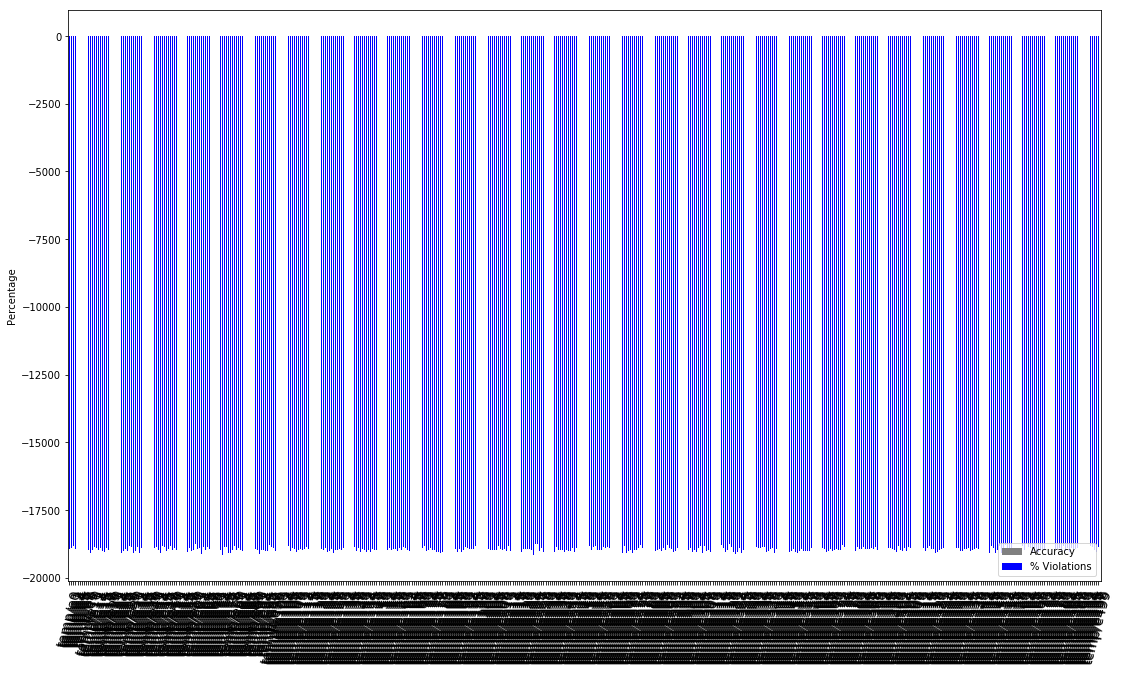

temp/e0
Area under surface (rectangular approx) =  58.65155947295414
Violations =  0.0
Average_violations =  -18948.44493457977
MSE =  1.040246978564548
temp/e1
Area under surface (rectangular approx) =  61.9165212491274
Violations =  0.0
Average_violations =  -18905.375589873594
MSE =  1.03996163087596
temp/e2
Area under surface (rectangular approx) =  66.1116090538109
Violations =  0.0
Average_violations =  -18839.23396812999
MSE =  1.041794294316458
temp/e3
Area under surface (rectangular approx) =  58.75794111752265
Violations =  0.0
Average_violations =  -18930.30589704993
MSE =  1.0299412499772722
temp/e4
Area under surface (rectangular approx) =  57.55640403771297
Violations =  0.0
Average_violations =  -19103.64239245923
MSE =  1.0355111129865768
temp/e5
Area under surface (rectangular approx) =  57.595040368524906
Violations =  0.0
Average_violations =  -18893.952900578144
MSE =  1.0346664572300797
temp/e6
Area under surface (rectangular approx) =  58.45653295212577
Violations

Violations =  0.0
Average_violations =  -18825.35450204778
MSE =  1.0320595597695434
temp/e256
Area under surface (rectangular approx) =  57.31770638398645
Violations =  0.0
Average_violations =  -18996.971432229027
MSE =  1.0350901333219602
temp/e257
Area under surface (rectangular approx) =  63.32264889523736
Violations =  0.0
Average_violations =  -18966.78817315948
MSE =  1.0428922955455608
temp/e258
Area under surface (rectangular approx) =  60.53844297222125
Violations =  0.0
Average_violations =  -18977.864463239035
MSE =  1.0390637039018258
temp/e259
Area under surface (rectangular approx) =  60.27255453865091
Violations =  0.0
Average_violations =  -18883.369636020838
MSE =  1.036635325659843
temp/e260
Area under surface (rectangular approx) =  59.552971223399595
Violations =  0.0
Average_violations =  -18887.791176310908
MSE =  1.0393964020521347
temp/e261
Area under surface (rectangular approx) =  62.93061177924591
Violations =  0.0
Average_violations =  -18882.63858403489
M

Average_violations =  -18991.158885459874
MSE =  1.0350916103952372
temp/e478
Area under surface (rectangular approx) =  62.81741391422402
Violations =  0.0
Average_violations =  -18923.680129219185
MSE =  1.0454281445430114
temp/e479
Area under surface (rectangular approx) =  59.50562547862484
Violations =  0.0
Average_violations =  -18929.538212132087
MSE =  1.0369650439715496
temp/e480
Area under surface (rectangular approx) =  57.65874729333392
Violations =  0.0
Average_violations =  -18895.23396873881
MSE =  1.033115937212191
temp/e481
Area under surface (rectangular approx) =  59.57925682048956
Violations =  0.0
Average_violations =  -19001.78163811108
MSE =  1.039469096902585
temp/e482
Area under surface (rectangular approx) =  63.21570120235111
Violations =  0.0
Average_violations =  -18838.680254348386
MSE =  1.04128379849578
temp/e483
Area under surface (rectangular approx) =  57.66576340972467
Violations =  0.0
Average_violations =  -19027.52872354413
MSE =  1.03371289006412

In [6]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    #heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
#heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    
#VIO = np.abs(VIO)
#VIO2 = np.abs(VIO2)


0.5909303967231058


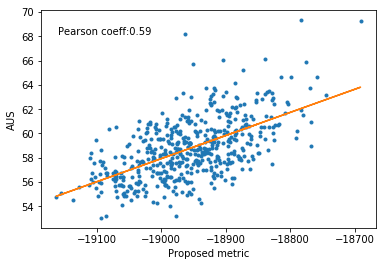

0.6482452661966371


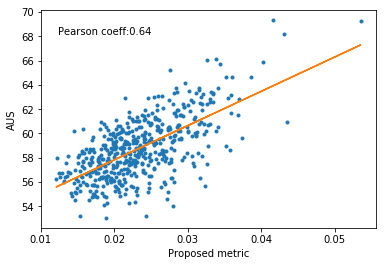

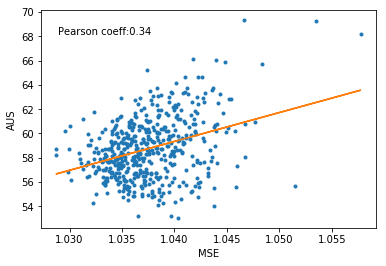

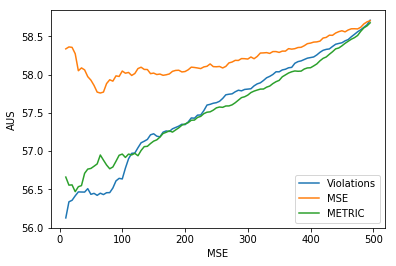

0.6482452661966371

In [11]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text


print(pearsonr(VIO,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = -(VIO/np.max(VIO)) + np.array(MSE)
print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]